# Requirements to collpase requirements tables Note + Making Concordances Concord - Tony Gui

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.api import VAR
import os
from data_cleaning_functions import requirements_clean, concordance_PCE_clean, \
    find_intermediate_industries, concordance_PCQ_clean, get_sales_from_make_matrix, clean_make_matrix, \
    get_demand_shock_from_shaipro_output, get_expenditure_weights_from_shapiro_outputs,plot_shapiro_graph_from_shapiro_ouput,clean_bea_PQE_table

from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, message=".*concatenation with empty or all-NA entries is deprecated.*")

script_dir = str(Path().resolve().parent)
file_path = os.path.join(script_dir) + "/" 
shapiro_file =  file_path + "Shapiro"
raw_data_path = file_path + "raw_bea_data" 

In [2]:
import sys

notebook_dir = os.getcwd()
# folder that contains NS_functions
package_parent = os.path.abspath(os.path.join(notebook_dir, ".."))   # -> .../shocks_productionnetworks
print("package_parent =", package_parent)

if package_parent not in sys.path:
    sys.path.insert(0, package_parent)   # put it first so it takes precedence
    print("Inserted package_parent into sys.path")
else:
    print("package_parent already in sys.path")


import importlib
try:
    import NS_functions as NS
    importlib.reload(NS)   # force a fresh load
    print("Imported NS_functions OK. Contents:", [n for n in dir(NS) if not n.startswith("_")])
except Exception as e:
    import traceback; traceback.print_exc()

import os
print("Files in notebook dir:", os.listdir(os.getcwd()))
print("NS_functions folder present at expected parent?:", os.path.isdir(os.path.join(package_parent, "NS_functions")))
print("Any NS_functions*.py in notebook dir?:", [f for f in os.listdir(os.getcwd()) if f.startswith("NS_functions")])


package_parent = /Users/Nick/Desktop/github testing/ShapirIO_new/shocks_productionnetworks
Inserted package_parent into sys.path
Imported NS_functions OK. Contents: ['SolverParams', 'analyticalJacobean', 'analytical_jacobian_template', 'batch_counterfactual_solver', 'batch_counterfactual_solver_SD_only', 'newton_raphson_solver', 'newton_solver']
Files in notebook dir: ['.DS_Store', 'Run Me.ipynb', 'data_cleaning_functions.py', '__pycache__', 'temp_file_for_testing.pkl', 'Requirements to collpase requirements tables backup.ipynb', 'Run Me CES.ipynb']
NS_functions folder present at expected parent?: True
Any NS_functions*.py in notebook dir?: []


# 1. Load in Requirements Matrix 

In [3]:
requirements = pd.read_excel(os.path.join(raw_data_path, 'IxI_TR_2017_PRO_Det.xlsx'), sheet_name='2017')
requirements = requirements_clean(requirements)
# requirements

# 2. Calculate Delta

In [4]:
requirements = requirements.T
with pd.option_context("future.no_silent_downcasting", True):
    requirements = requirements.fillna(0).infer_objects(copy=False)
delta = np.identity(len(requirements)) - np.linalg.inv(requirements)

# 2 (Making Concordances Concord) Adding Scrap, Used and secondhand goods and ROW adjustments to Delta

In [5]:
"""These 4 industries are found in the concordance table but not in the Reqirements table so I am 
adding them manually with row and column inputs of zero"""
concordance_but_not_requirments = ["Scrap", "Used and secondhand goods", "Rest of the world adjustment", "noncomparable imports"] 
delta = pd.DataFrame(delta, index=requirements.index, columns=requirements.columns)
delta = delta.reindex(index=requirements.index.append(pd.Index(concordance_but_not_requirments)).str.lower() , columns=requirements.columns.append(pd.Index(concordance_but_not_requirments)).str.lower() , fill_value=0)

# delta

# 2.5b Making Negative Values in Delta Zero

In [6]:
negative_count = (delta < 0).sum().sum()
x = negative_count/402**2
delta[delta < 0] = 0
negative_count_new = (delta < 0).sum().sum()
y = negative_count_new/402**2

# 2.5b Force negatives to be zero but adjust row sums to be same as before

In [7]:
# V = delta.sum(axis=0)
# P = delta[delta > 0].sum()
# delta.loc['norm'] = V/P
# last_values = delta.iloc[-1]
# delta[delta < 0] = 0
# delta = delta.iloc[:-1].div(last_values)
# delta

# Dealting with Intermediate Industries - Making Concordances Concord Section 3.3.1. - Operationalizing Industries without Products

# Step 1. Making Concordances Concord

In [8]:
use_table = pd.read_excel(os.path.join(raw_data_path, "Use_SUT_Framework_2017_DET.xlsx"), sheet_name="2017")

# Returns all industries with zero PCE 
intermediate_industries = find_intermediate_industries(use_table)

intermediate_industries = intermediate_industries.iloc[:, [0]]
intermediate_industries = intermediate_industries.sort_values(by="Industry")
# intermediate_industries

# Steps 2 - 5. Making Concordances Concord - Loop over Intermediate Industries and Remove

In [9]:
# For the Loop 
big_lambda = np.eye(len(delta)) # create a big_lambda identity matrix that will become out final output
big_lambda = pd.DataFrame(big_lambda)
big_lambda = big_lambda.set_index(delta.index)
big_lambda.columns = delta.index
delta_industries = delta.index # save all the requirment table industries outside the loop 
removed = [] # stores all removed industries through the loop 

i = 0
for row in intermediate_industries.iloc[::-1].itertuples(): # looping backwards
    i += 1 
    current = row.Industry # industry we are currently removing
    # Create identity matrix for current loop iteration
    phi_i = np.eye(len(delta) - (i - 1))
    phi_i = pd.DataFrame(phi_i)
    phi_i = phi_i.set_index(delta_industries)
    phi_i.columns = delta_industries

    current_intermediate_use_table = delta.copy() # use a new intermediates use matrix each time we do this
    # Remove all the industries we've previously removed in earlier loop iterations 
    current_intermediate_use_table.drop(columns=removed, inplace=True)
    current_intermediate_use_table = current_intermediate_use_table.loc[[current]] # the row of the intermediates use table associated with the current industry  
    current_intermediate_use_table.drop(columns=[current], inplace=True) # drop the column associated with the current industry so we dont include it in our sum
    current_intermediate_use_table = current_intermediate_use_table.astype(float)
    current_industry_sum = current_intermediate_use_table.loc[current].sum() # find sum of row

    # just making sure that we aren't dividing by zero 
    if current_industry_sum != 0:
        current_intermediate_use_table = current_intermediate_use_table.astype(float)
        current_intermediate_use_table.loc[current] = current_intermediate_use_table.loc[current] / current_industry_sum


    current_intermediate_use_table = current_intermediate_use_table[sorted(current_intermediate_use_table.columns)] # sort the normazlied row alphabetically

    # remove the current industry from intermediate list
    intermediate_industries = intermediate_industries[intermediate_industries['Industry'] != current]
    # drop the current industry column from phi_i and industry indexing
    phi_i = phi_i.drop(columns=current)
    delta_industries = delta_industries.drop(current) 
    
    removed.append(current)

    # Update phi_i with the current industry sale shares
    phi_i.loc[current_intermediate_use_table.index] = current_intermediate_use_table.loc[current_intermediate_use_table.index].astype(np.float64).values
    big_lambda_old = big_lambda
    big_lambda = big_lambda @ phi_i

# Step 6. Making Concordances Concord - Converting IO matrix from sales shares to dollars

In [10]:
make_matrix = pd.read_excel(os.path.join(raw_data_path, "Supply_2017_DET.xlsx"), sheet_name="2017")
sales_vector = get_sales_from_make_matrix(make_matrix) # returns the sales for each industry

# these industries are not in the make matrix so i will add them manually with zero entries to preserve df sizes
industries_not_in_make_matrix = ["state and local government passenger transit", "state and local government electric utilities", \
                      "secondary smelting and alloying of aluminum", "federal electric utilities"]
not_in_make_matrix = pd.DataFrame({'Industries': industries_not_in_make_matrix, 'Sales': [0,0,0,0]})
sales_vector = pd.concat([sales_vector, not_in_make_matrix], ignore_index=True)
sales_vector.set_index('Industries', inplace=True)

# repeat the sales vector n times to make a sales matrix
sales_repeated = pd.DataFrame({f'{i}': sales_vector['Sales'].values for i in range(1, len(delta))})
sales_repeated.set_index(sales_vector.index, inplace=True)
sales_matrix = pd.concat([sales_vector, sales_repeated], axis=1)
sales_matrix.columns = delta.columns

# Y is IO matrix in dollars 
Y = delta * sales_matrix 

# Step 7. Making Concordances Concord - Value Added for the Economy

In [11]:
sum_Y = Y.sum(axis=1).to_frame()
sum_Y.columns = ['Sales']
VA_pre_transformation = (sales_vector - sum_Y).sum()

# Step 8. Making Concordances Concord - IO Matrix in USD

In [12]:
# new IO matrix in USD 
Y_tilde = big_lambda.T @ Y @ big_lambda
sales_tilde = big_lambda.T @ sales_vector

# Verifing that economy wide value added is identical to the pre-transformation level
sum_Y_tilde = Y_tilde.sum(axis=1).to_frame()
sum_Y_tilde.columns = ['Sales']
VA_post_transformation = (sales_tilde - sum_Y_tilde).sum()
# VA_post_transformation

In [13]:
"""Pre transformation and post transformation are not the same"""
differnece = VA_post_transformation - VA_pre_transformation
differnece

Sales   -938.752332
dtype: float64

# Step 9. Making Concordances Concord - Calculating New Delta

In [14]:
recip_sales = 1/sales_tilde
sales_tilde_repeated = pd.DataFrame({f'{i}': recip_sales['Sales'].values for i in range(1, len(delta))})
sales_tilde_repeated.set_index(recip_sales.index, inplace=True)
sales_tilde_matrix = pd.concat([recip_sales, sales_tilde_repeated], axis=1)
sales_tilde_matrix.columns = delta.columns

delta_tilde = Y_tilde * sales_tilde_matrix
delta = delta_tilde
# delta

# End of Making Concordances Concord - Back to Requirements to Collapse Requirements Table

# 3. Merge Concordance with Delta

In [15]:
concordance = pd.read_excel(os.path.join(raw_data_path, "PCEBridge_2017_DET.xlsx"), sheet_name="2017")
concordance = concordance_PCE_clean(concordance)
# concordance

In [16]:
"""the problem here is some industries in the requirments matrix still have no match to PCE they are matching to PEQ so i must drop them here when im trying to 
make the requirments table in terms of products however im not sure if this changes some of the math performed to the requirments matrix ie delta later on
"""
industries_in_requirments = set(delta.columns)
indsutries_in_concordance = set(concordance["PCE Bridge Industries"])
industires_not_in_concordance = industries_in_requirments - indsutries_in_concordance
delta = delta.drop(index=industires_not_in_concordance, columns=industires_not_in_concordance, errors='ignore')
# delta

In [17]:
in_num_products = concordance['PCE Bridge Industries'].value_counts()

delta_product_columns = pd.DataFrame(index=delta.index, columns=concordance['PCE Bridge Products'])

for column in delta_product_columns: 
    industry = concordance.loc[concordance['PCE Bridge Products'] == column, 'PCE Bridge Industries'].values
    delta_product_columns[column] = delta[industry] / in_num_products[industry]

delta_product_cr = pd.DataFrame(columns=delta_product_columns.columns)
lst_for_industry = []
for row in delta_product_columns.index:
    final_value = delta_product_columns.loc[row] / in_num_products[row]
    products = concordance[concordance['PCE Bridge Industries'] == row]['PCE Bridge Products'].tolist()
    for product in products: 
        lst_for_industry.append(row)
        final_value_row = pd.DataFrame(final_value).T
        final_value_row.index = [product]
        
        delta_product_cr = pd.concat([delta_product_cr, final_value_row])

industry = pd.DataFrame(lst_for_industry, columns=['industry'])
industry.index = delta_product_cr.index
delta_product_cr = pd.concat([delta_product_cr, industry], axis = 1)
# delta_product_cr

# 4. Collapse columns

In [18]:
delta_products = delta_product_cr.T.groupby(delta_product_cr.columns).sum().T
# delta_products

# 5. Make Matrix to Sales

In [19]:
make_matrix = pd.read_excel(os.path.join(raw_data_path, "Supply_2017_DET.xlsx"), sheet_name='2017')
sales = get_sales_from_make_matrix(make_matrix)
# sales

# 6. Merge concordance with sales 

In [20]:
product_sales = pd.merge(concordance, sales, left_on='PCE Bridge Industries', right_on='Industries')
product_sales = product_sales[["PCE Bridge Products", "Industries", 'Sales']]
# product_sales

# 7. Group sum of Sales for every Product

In [21]:
# calculates the number of product categories an Industry belongs to 
product_sales['In#Products'] = product_sales['Industries'].map(product_sales['Industries'].value_counts())
product_sales["Ratio_in_Product"] = product_sales['Sales'] / product_sales['In#Products'] 
product_sales['Sales_Sum'] = product_sales.groupby('PCE Bridge Products')['Ratio_in_Product'].transform('sum')
# product_sales

# 8. Sales Share 

In [22]:
product_sales['Sale Share'] = product_sales["Ratio_in_Product"] / product_sales["Sales_Sum"]
product_sales = product_sales.rename(columns={'Industries': 'industry'})
product_sales = product_sales.rename(columns={'PCE Bridge Products': 'product'})
# product_sales

# 9. Merge Sale shares and Delta

In [23]:
df_reset = delta_products.reset_index()
delta_products = df_reset.rename(columns={'index': 'product'})
delta_products_saleshare = delta_products.merge(product_sales, how = 'inner', on = ['industry', 'product'])
delta_products_saleshare = delta_products_saleshare.drop(columns=['Sales_Sum', "Ratio_in_Product", "In#Products", "Sales", "industry"])
delta_products_saleshare = delta_products_saleshare.set_index(delta_products_saleshare.columns[0])
# delta_products_saleshare

# 10. weightTimesDeltaValue + 11.

In [24]:
# Convert from Wide to Long
delta_final = delta_products_saleshare.reset_index().melt(id_vars=[delta_products_saleshare.index.name, "Sale Share"],
                                var_name="Column Products", value_name="value")

# Just Renaming and Reordering
delta_final = delta_final.rename(columns={delta_products_saleshare.index.name: "Row Products"})
delta_final = delta_final[['Row Products', 'Column Products', 'value', 'Sale Share']]
# Calculating weightTimesDeltaValue
delta_final["weightTimesDeltaValue"] = delta_final["value"] * delta_final["Sale Share"]

# Sum weightTimesDeltaValue grouping by Row Products AND Column Products
delta_final = delta_final.groupby(['Row Products', 'Column Products']).sum()
delta_final
# Convert Back to Wide Format 
delta_final = delta_final.pivot_table(values='weightTimesDeltaValue', index='Row Products', columns='Column Products')

# Removes Index and Column Names cuz it looks better. Both Index and Columns are simply Product Categories now
delta_final.columns.name = None 
delta_final.index.name = None 


labels_to_drop = ["government employees' expenditures abroad", "private employees' expenditures abroad","u.s. travel outside the united states","u.s. student expenditures"]
delta_final = delta_final.drop(index=labels_to_drop, columns=labels_to_drop, errors="ignore")

# delta_final

# Fixing Products with no price, quantity or expendiuture data 

In [25]:
bea_quantities = pd.read_excel(os.path.join(raw_data_path, 'BEA Monthly Quantities.xlsx'))
bea_quantities = clean_bea_PQE_table(bea_quantities, "Quantities", long=True)
bea_quantities = bea_quantities[bea_quantities['products'].isin(delta_final.index)]
bea_quantities = bea_quantities.drop_duplicates()
bea_quantities['Quantities'] = bea_quantities['Quantities'].replace('---', 0).astype(float)
bea_quantities = bea_quantities.fillna(0)

bea_prices = pd.read_excel(os.path.join(raw_data_path, 'BEA Monthly Prices.xlsx'))
bea_prices = clean_bea_PQE_table(bea_prices, "Prices", long=True)
bea_prices = bea_prices[bea_prices['products'].isin(delta_final.index)]
bea_prices = bea_prices.drop_duplicates()
bea_prices['Prices'] = bea_prices['Prices'].replace('---', 0).astype(float)
bea_prices = bea_prices.fillna(0)

bea_expenditures = pd.read_excel(os.path.join(raw_data_path, 'BEA Monthly Expenditures.xlsx'))
bea_expenditures = clean_bea_PQE_table(bea_expenditures, "Expenditures", long=True)
bea_expenditures = bea_expenditures[bea_expenditures['products'].isin(delta_final.index)]
bea_expenditures = bea_expenditures.drop_duplicates()
bea_expenditures['Expenditures'] = bea_expenditures['Expenditures'].replace('---', 0).astype(float)
bea_expenditures = bea_expenditures.fillna(0)

bea_PQE_merged = pd.merge(left=bea_quantities, right=bea_prices, on=['products', 'date'], how='outer')
bea_PQE_merged = pd.merge(left=bea_PQE_merged, right=bea_expenditures, on=['products', 'date'], how='outer')

# dropping this because 2024-10 has no data yet 
bea_PQE_merged = bea_PQE_merged.dropna(subset=['Expenditures'])

dates = list(set(bea_expenditures["date"]) & set(bea_prices["date"]) & set(bea_quantities["date"]))
dates.sort()

cols_to_check = ['Quantities', 'Prices', 'Expenditures']

# Create filtered DataFrame where at least one value is missing or zero
products_with_zero_somwhere = bea_PQE_merged[
    bea_PQE_merged[cols_to_check].isnull().any(axis=1) |
    (bea_PQE_merged[cols_to_check] == 0).any(axis=1)
]

all_bad_products_dict = {}

for date in dates:
    bad_products_currnet = products_with_zero_somwhere[products_with_zero_somwhere['date'] == date]["products"]
    all_bad_products_dict[date] = bad_products_currnet.tolist()


""""Tony experimental"""
zero_mask = (bea_PQE_merged[cols_to_check] == 0).any(axis=1)
# Set all three columns to 0 where the mask is True
bea_PQE_merged.loc[zero_mask, cols_to_check] = 0

bea_prices = bea_PQE_merged[["products", "date", "Prices"]]

/var/folders/hx/h9ft_v812fs68lgk203tqsq80000gn/T/ipykernel_87714/429633537.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bea_quantities['Quantities'] = bea_quantities['Quantities'].replace('---', 0).astype(float)
/var/folders/hx/h9ft_v812fs68lgk203tqsq80000gn/T/ipykernel_87714/429633537.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bea_quantities = bea_quantities.fillna(0)
/var/folders/hx/h9ft_v812fs68lgk203tqsq80000gn/T/ipykernel_87714/429633537.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be rem

# 12. Calculate Gamma

In [26]:
row_sums = delta_final.sum(axis=1)
gamma = pd.DataFrame(row_sums, columns=['Row_Sum'])
gamma.index = delta_final.index 
gamma = gamma.apply(pd.to_numeric, errors='coerce')
# gamma

# 13. Calculate Omega

In [27]:
delta_gamma = delta_final.merge(gamma, left_on=gamma.index, right_on=delta_final.index)
delta_gamma = delta_gamma.set_index(delta_gamma.columns[0])
row_sums = delta_gamma.iloc[:, -1]
row_sums[row_sums == 0] = np.nan
omega = delta_gamma.iloc[:, :-1].div(row_sums, axis=0)
omega.columns.name = None 
omega.index.name = None 
omega = omega.apply(pd.to_numeric, errors='coerce')
# omega

/var/folders/hx/h9ft_v812fs68lgk203tqsq80000gn/T/ipykernel_87714/3235453765.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row_sums[row_sums == 0] = np.nan


# Different gamma and omega for missing products

In [28]:
gamma_omega_monthly = {} # this will store a different gamma and omega for each month

for date in all_bad_products_dict:

    zero_products = all_bad_products_dict.get(date) # products that have no time series data for current month

    current_gamma = gamma.copy()
    current_delta = delta_final.copy()

    for product in zero_products:
        current_gamma.loc[current_gamma.index == product, 'Row_Sum'] = 0 # making missing sector expenditure 0 
        if product in delta_final.columns: 
            current_delta[product] = 0 # missing time series products dont sell to any other sector
            
    current_row_sum = current_delta.sum(axis=1)

    current_omega = current_delta.div(current_row_sum, axis=0)
    checking_omega = current_omega

    current_omega.columns.name = None 
    current_omega.index.name = None 
    current_omega = current_omega.apply(pd.to_numeric, errors='coerce')

    gamma_omega_monthly[date] = [current_gamma, current_omega]

# Start of Doing our Supply/demand contribution graph properly (Which influenceer has hte most influence?)

# Find Sales

In [29]:
# calculate sales in product and time period
sales = pd.DataFrame({'date': pd.Series(dtype='datetime64[ns]'),
                   'products': pd.Series(dtype='str'),
                   'sales': pd.Series(dtype='float')})

for date in dates:

    gamma = gamma_omega_monthly.get(date)[0]
    omega = gamma_omega_monthly.get(date)[1]
 
    # filter expenditures for the current date
    expenditures_date = bea_expenditures[bea_expenditures['date'] == date][['products', 'Expenditures']].set_index('products')
    expenditures_date = expenditures_date.sort_index()
    expenditures_date = expenditures_date.apply(pd.to_numeric, errors='coerce')

    gamma_series = gamma["Row_Sum"]
    diag_matrix = np.diag(gamma_series)

    x = np.identity(len(omega)) - (omega.T @ diag_matrix)

    sales_date = np.linalg.inv(x) @ expenditures_date

    sales_date['date'] = date
    sales_date['products'] = expenditures_date.index
    sales_date.rename(columns={'Expenditures': 'sales'}, inplace=True)

    sales = pd.concat([sales, sales_date], ignore_index=True)

# Find Prices of Intermediates

In [30]:
# calculate prices of intermediates (we use cobb douglas production with intermediates)
σ = 0.1     # Intermediates elasticity of substitution

#intermediates = pd.DataFrame({'date': pd.Series(dtype='datetime64[ns]'),
#                   'products': pd.Series(dtype='str'),
#                   'intermediates': pd.Series(dtype='float')})
#for date in dates:

#    prices_date = bea_prices[bea_prices['date'] == date][['products', 'Prices']].set_index('products')
#    prices_date = prices_date.sort_index()

#    gamma = gamma_omega_monthly.get(date)[0]
#    omega = gamma_omega_monthly.get(date)[1]
    
#    for i in gamma.index:
#        scale_prices = prices_date['Prices']**(1-σ)
#        scale_prices.replace(-np.inf, 0, inplace=True)        
#        intermediates.loc[len(intermediates)] = [date, i, (omega.loc[i] @ scale_prices)**(1/(1-σ))]

# Find Price of Value Added

In [31]:
# calculate prices of value added
value_added = pd.DataFrame({'date': pd.Series(dtype='datetime64[ns]'),
                   'products': pd.Series(dtype='str'),
                   'value_added': pd.Series(dtype='float')})

ϵ = 0.8       # Elasticitiy of substitution between value added and intermediates
σ = 0.1
for date in dates:
    # filter prices for the current date
    prices_date = bea_prices[bea_prices['date'] == date][['products', 'Prices']].set_index('products')
    prices_date = prices_date.sort_index()

    # filter intermediates for the current date
    #intermediates_date = intermediates[intermediates['date'] == date][['products', 'intermediates']].set_index('products')
    #intermediates_date = intermediates_date.sort_index()

    gamma = gamma_omega_monthly.get(date)[0]    
    gamma_series = gamma["Row_Sum"]

    #value_added_date = np.exp((1/(1 - gamma_series.sort_index()))*(np.log(prices_date['Prices']) - gamma_series.sort_index() * np.log(intermediates_date['intermediates'])))
    value_added_date = ((1/(1 - gamma_series.sort_index()))*(prices_date['Prices']**(1-ϵ) - gamma_series.sort_index() * (omega @ prices_date['Prices']**(1-σ))**((1-ϵ)/(1-σ))))**(1/(1-ϵ))

    #error_use = prices_date['Prices']**(1-ϵ) - (1-gamma_series) *value_added_date**(1-ϵ) - gamma_series * intermediates_date['intermediates']**(1-ϵ)
    error_use2 = prices_date['Prices']**(1-ϵ) - (1-gamma_series) *value_added_date**(1-ϵ) - gamma_series * (omega @ prices_date['Prices']**(1-σ))**((1-ϵ)/(1-σ))
    #P_int = (omega @ prices_date['Prices']**(1-σ))**(1/(1-σ))

    if np.abs(error_use2).max()>1e-7:
        error()

    value_added_date = value_added_date.reset_index().rename(columns={0: 'value_added'})
    value_added_date['date'] = date
    value_added_date.rename(columns={"index": "products"}, inplace=True)

    if date==dates[0]:
        date_save = value_added_date
        price_save = prices_date

    value_added = pd.concat([value_added, value_added_date], ignore_index=True)

# Sales and Value Added VAR

In [32]:
lags = 12
residuals_part = []

for product in gamma.index:
    product_bad_dates = products_with_zero_somwhere[products_with_zero_somwhere["products"] == product]
    calculated = pd.merge(left=value_added, right=sales, on=['products', 'date'], how='inner')
    calculated = calculated[calculated['products'] == product][['date', 'value_added', 'sales']].sort_values(['date'])
    calculated = calculated.set_index('date')

    if not product_bad_dates.empty: 
        calculated = calculated[~calculated.index.isin(product_bad_dates['date'])] # remove rows before we have all time series data
    
    calculated['value_added'] = np.log(calculated['value_added']).diff()
    calculated['sales'] = np.log(calculated['sales']).diff()

    calculated.replace([np.inf, -np.inf, np.nan], 0, inplace=True)

    full_index_calc = pd.date_range(start=calculated.index.min(), end=calculated.index.max(), freq='MS')
    calculated = calculated.reindex(full_index_calc)

    model_calculated = VAR(calculated)
    result_calculated = model_calculated.fit(lags)

    residuals_calculated = result_calculated.resid.reset_index()
    residuals_calculated['products'] = product
    
    residuals_part.append(residuals_calculated)

IO_residuals = pd.concat(residuals_part, ignore_index=True)
IO_residuals.rename(columns={'index': 'date', 'value_added': 'residual_value_added', 'sales': 'residual_sales'}, inplace=True)
IO_residuals = IO_residuals.groupby(['date', 'products']).sum(min_count=1).reset_index()
IO_residuals = IO_residuals.sort_values(['date', 'products'])

# Price and Quantity VAR

In [33]:
lags = 12
residual_temp = []

for product in gamma.index:

    original = bea_PQE_merged[bea_PQE_merged['products'] == product][['date', 'Prices', 'Quantities']].sort_values(['date'])
    original = original.set_index('date')

    original.dropna(inplace=True)

    original['Prices'] = np.log(original['Prices']).diff()
    original['Quantities'] = np.log(original['Quantities']).diff()
     

    original.replace([np.inf, -np.inf], np.nan, inplace=True)
    original.dropna(inplace=True)

    full_index = pd.date_range(start=original.index.min(), end=original.index.max(), freq='MS')
    original = original.reindex(full_index)

    model_original = VAR(original)
    result_original = model_original.fit(lags)

    residuals_original = result_original.resid.reset_index()
    residuals_original['products'] = product
    
    residual_temp.append(residuals_original)
    
residuals_normal = pd.concat(residual_temp, ignore_index=True)
residuals_normal.rename(columns={'index': 'date', 'Prices': 'residual_prices', 'Quantities': 'residual_quantities'}, inplace=True)
residuals_normal = residuals_normal.groupby(['date', 'products']).sum(min_count=1).reset_index()
residuals_normal = residuals_normal.sort_values(['date', 'products'])

/Users/Nick/Desktop/github testing/ShapirIO_new/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Nick/Desktop/github testing/ShapirIO_new/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Nick/Desktop/github testing/ShapirIO_new/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Nick/Desktop/github testing/ShapirIO_new/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Nick/Desktop/github testing/ShapirIO_new/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide 

# Classification of Price of Value Added and Real Production

In [34]:
residuals_normal['majority_demand'] = ((residuals_normal['residual_prices'] * residuals_normal['residual_quantities']) >= 0).astype(int)
residuals_normal['majority_supply'] = ((residuals_normal['residual_prices'] * residuals_normal['residual_quantities']) < 0).astype(int)

IO_residuals['majority_demand_a'] = ((IO_residuals['residual_value_added'] * IO_residuals['residual_sales']) >= 0).astype(int)
IO_residuals['majority_supply_a'] = ((IO_residuals['residual_value_added'] * IO_residuals['residual_sales']) < 0).astype(int)

# Start of Nick's Code here: Let's run a decomposition one at a time for a price vector



In [247]:
bea_prices[(bea_prices['date'].dt.year==1980)&(bea_prices['date'].dt.month==12)]

,products,date,Prices
263,accessories and parts,1980-12-01,63.057
1053,air transportation,1980-12-01,64.910
1843,alcohol in purchased meals,1980-12-01,25.822
2633,all other professional medical services,1980-12-01,0.000
3423,"amusement parks, campgrounds, and related recr...",1980-12-01,35.521
...,...,...,...
162213,water transportation,1980-12-01,88.952
163003,window coverings,1980-12-01,127.809
163793,wine,1980-12-01,57.898
164583,women's and girls' clothing,1980-12-01,109.479


In [248]:
bea_prices[(bea_prices['date'].dt.year==1981)&(bea_prices['date'].dt.month==1)]

,products,date,Prices
264,accessories and parts,1981-01-01,63.572
1054,air transportation,1981-01-01,66.291
1844,alcohol in purchased meals,1981-01-01,26.179
2634,all other professional medical services,1981-01-01,0.000
3424,"amusement parks, campgrounds, and related recr...",1981-01-01,35.763
...,...,...,...
162214,water transportation,1981-01-01,89.905
163004,window coverings,1981-01-01,128.021
163794,wine,1981-01-01,58.947
164584,women's and girls' clothing,1981-01-01,109.483


In [ ]:

contribs = pd.DataFrame(data = value_added[['date','products']])
contribs = pd.merge(contribs,IO_residuals[['date','products','majority_demand_a']],on=['date','products'],how='left')
contribs.loc[contribs['majority_demand_a'].isna(),'majority_demand_a']=2
contribs['shares']=0
contribs['CPI']=0
contribs['CPI_hat']=0
contribs_save = contribs.copy()
contribs_save = contribs[['date','majority_demand_a','shares']].groupby(['date','majority_demand_a']).sum().reset_index()
date_list = value_added['date'].unique()

dcount=0
hcount=0
for d in range(1,len(date_list)):
    date = date_list[d]
    date_last = date_list[d-1]

    #print(date)

    # Setup proper matrices and shares.
    PVA = value_added.loc[value_added['date']==date,'value_added'].to_numpy()
    PVA_last = value_added.loc[value_added['date']==date_last,'value_added'].to_numpy()
    PVA_hat = 0*PVA + 1
    PVA_hat[PVA_last!=0] = PVA[PVA_last!=0]/PVA_last[PVA_last!=0]

    P_vec = bea_prices.loc[date==bea_prices['date'],'Prices'].to_numpy()
    P_vec_last = bea_prices.loc[date_last==bea_prices['date'],'Prices'].to_numpy()
    P_vec_hat = 0*P_vec + 1
    P_vec_hat[P_vec_last!=0] = P_vec[P_vec_last!=0]/P_vec_last[P_vec_last!=0]

    baseColumnIndicies = contribs.loc[contribs['date']==date,'majority_demand_a'].to_numpy()


    gamma = gamma_omega_monthly.get(date_last)[0].to_numpy().reshape(-1)
    omega = gamma_omega_monthly.get(date_last)[1].to_numpy()

    weights = bea_expenditures.loc[bea_expenditures['date']==date,'Expenditures'].to_numpy()
    weights_last = bea_expenditures.loc[bea_expenditures['date']==date_last,'Expenditures'].to_numpy()

    # CPI hat is complicated because of chain linking. Weights on each P_vec_hat are weights * P_vec / sum(weights * P_Vec_last)
    weights = weights/weights.sum()
    weights_last = weights_last/weights_last.sum()
    CPI_weights = (weights * P_vec_last /(.   @ P_vec_last)) 

    CPI_hat = CPI_weights @ P_vec_hat
    CPI = weights @ P_vec

    error_check = P_vec_hat**(1-ϵ) -  (1-gamma.reshape(-1)) * PVA_hat**(1-ϵ) - gamma.reshape(-1) * (omega @ P_vec_hat**(1-σ))**((1-ϵ)/(1-σ))

    if np.abs(error_check).max()>1e-7:
        PVA2 = ((P_vec_hat**(1-ϵ) - gamma.reshape(-1) * (omega @ P_vec_hat**(1-σ))**((1-ϵ)/(1-σ)))/(1-gamma))**(1/(1-ϵ))
    else:
        PVA2 = PVA_hat


    error_check2 = P_vec_hat**(1-ϵ) -  (1-gamma) * PVA2**(1-ϵ) - gamma * (omega @ P_vec_hat**(1-σ))**((1-ϵ)/(1-σ))
    if np.abs(error_check2).max()>1e-7:
        error()

    #import pickle
    #filename = "/Users/Nick/Desktop/github testing/ShapirIO_new/shocks_productionnetworks/NS_functions/temp_file_for_testing.pkl"

    #with open(filename,'wb') as file:
    #    pickle.dump([ϵ, σ, gamma, omega, PVA2,P_vec_hat,CPI_weights,baseColumnIndicies],file)

    indices_to_test=np.arange(3)



    #params = NS.SolverParams(ϵ, σ, gamma, omega, PVA2)
    #batch_results = NS.batch_counterfactual_solver_SD_only(
    #    P_vec_baseline=P_vec_hat,
    #    params_baseline=params,
    #    indices_to_perturb=indices_to_test,
    #    weights = weights,
    #    derivative_option=4,  
    #    analytical_jac_func = NS.analytical_jacobian_template,
    #    tol_residual=1e-8,
    #    tol_step=1e-8,
    #    max_iter=100,
    #    verbose=False
    #)

    params = NS.SolverParams(ϵ, σ, gamma, omega, PVA2)
    batch_results = NS.batch_counterfactual_solver_SD_only(
        P_vec_baseline=P_vec_hat,
        params_baseline=params,
        basis_for_perturb = baseColumnIndicies,
        indices_to_perturb=indices_to_test,
        weights = CPI_weights,
        derivative_option=4,  
        analytical_jac_func = NS.analytical_jacobian_template,
        tol_residual=1e-8,
        tol_step=1e-8,
        max_iter=100,
        verbose=False
    )
    dcount+=1
    if dcount>100:
        dcount=0
        hcount+=1
        toprint = hcount*100
        print('Completed ',toprint,' dates out of ',len(date_list)-1)

    #print(sum(batch_results['convergence_status'])/len(indices_to_test))

    
    contrib_to_add = [(CPI_hat-i)/(CPI_hat-1) for i in batch_results['counterfactual_solutions']]
    for idx,i in enumerate(indices_to_test):

        contribs_save.loc[(contribs_save['date']==date)&(contribs_save['majority_demand_a']==i),'shares']=contrib_to_add[i]
        contribs_save.loc[(contribs_save['date']==date)&(contribs_save['majority_demand_a']==i),'CPI']=CPI
        contribs_save.loc[(contribs_save['date']==date)&(contribs_save['majority_demand_a']==i),'CPI_hat']=CPI_hat

        

/var/folders/hx/h9ft_v812fs68lgk203tqsq80000gn/T/ipykernel_87714/3559726392.py:110: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.4194792338930202' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  contribs_save.loc[(contribs_save['date']==date)&(contribs_save['majority_demand_a']==i),'shares']=contrib_to_add[i]


Completed  100  dates out of  788
Completed  200  dates out of  788
Completed  300  dates out of  788
Completed  400  dates out of  788
Completed  500  dates out of  788


/var/folders/hx/h9ft_v812fs68lgk203tqsq80000gn/T/ipykernel_87714/3559726392.py:50: RuntimeWarning: invalid value encountered in power
  PVA2 = ((P_vec_hat**(1-ϵ) - gamma.reshape(-1) * (omega @ P_vec_hat**(1-σ))**((1-ϵ)/(1-σ)))/(1-gamma))**(1/(1-ϵ))
/Users/Nick/Desktop/github testing/ShapirIO_new/shocks_productionnetworks/NS_functions/analyticalJacobean.py:87: RuntimeWarning: divide by zero encountered in scalar power
  direct_term = exp_price * (P_vec[i] ** (-epsilon))


NameError: name 'error' is not defined

In [205]:
# Calculate month-over-month inflation (should be equal to CPI_hat-1) 
# and then do a 12 month moving average on CPI and on shares

contribs_save['CPI_m_o_m'] = contribs_save.groupby('majority_demand_a')['CPI'].transform(lambda x: ((x - x.shift(1)) / x.shift(1)))

# 12 month rolling window of CPI and the shares
contribs_save['contribution_of_shocks'] = contribs_save['CPI_m_o_m']*contribs_save['shares']
vals = contribs_save['majority_demand_a'].unique()
for val in vals:

    contribs_save.loc[contribs_save['majority_demand_a']==val,'CPI_rolling'] = (contribs_save.loc[contribs_save['majority_demand_a']==val,'CPI_m_o_m'].add(1).shift(1).rolling(window=12, min_periods=12).apply(np.prod, raw=True) - 1) * 100
    contribs_save.loc[contribs_save['majority_demand_a']==val,'contribution_of_shocks_rolling'] = (contribs_save.loc[contribs_save['majority_demand_a']==val,'contribution_of_shocks'].add(1).shift(1).rolling(window=12, min_periods=12).apply(np.prod, raw=True) - 1) * 100


# Convert from long to wide for plotting
contribs_wide = contribs_save.pivot_table(index = 'date', columns='majority_demand_a', values=['CPI_rolling', 'contribution_of_shocks_rolling'])
contribs_wide.columns = ['CPI_rolling_0', 'CPI_rolling_1', 'CPI_rolling_2', 'contribution_of_shocks_rolling_0', 'contribution_of_shocks_rolling_1', 'contribution_of_shocks_rolling_2']
contribs_wide.drop(columns = ['CPI_rolling_1', 'CPI_rolling_2'],inplace=True)
contribs_wide.columns = ['CPI_rolling','Supply', 'Demand', 'Unclassified']

contribs_wide['Interaction'] = contribs_wide['CPI_rolling'] - contribs_wide['Supply'] - contribs_wide['Demand'] - contribs_wide['Unclassified']

In [232]:
contribs_save[740:].head(40)

,date,majority_demand_a,shares,CPI,CPI_hat,CPI_m_o_m,contribution_of_shocks,CPI_rolling,contribution_of_shocks_rolling
740,1980-03-01,2.0,-0.287687,53.350279,1.006559,0.006559,-0.001887,5.007027,0.011498
741,1980-04-01,0.0,0.875848,53.833173,1.009051,0.009051,0.007928,5.316089,2.257957
742,1980-04-01,1.0,0.419077,53.833173,1.009051,0.009051,0.003793,5.316089,2.648729
743,1980-04-01,2.0,0.294826,53.833173,1.009051,0.009051,0.002669,5.316089,-0.340642
744,1980-05-01,0.0,0.475777,54.097725,1.004914,0.004914,0.002338,6.038380,3.077582
745,1980-05-01,1.0,0.314877,54.097725,1.004914,0.004914,0.001547,6.038380,3.030762
746,1980-05-01,2.0,-0.209582,54.097725,1.004914,0.004914,-0.001030,6.038380,0.145028
747,1980-06-01,0.0,0.673106,54.445121,1.006422,0.006422,0.004322,6.531753,3.457576
748,1980-06-01,1.0,0.433285,54.445121,1.006422,0.006422,0.002782,6.531753,3.171569
749,1980-06-01,2.0,0.106241,54.445121,1.006422,0.006422,0.000682,6.531753,0.184404


In [206]:
colors_hex = [
    '#3582C2',  # [.21 .51 .76]
    '#FF8000',  # [1 .5 0]
     
    
    
    '#DCB5DF',  # [.8616 .7117 .8728]
    
    "#F4D432",  # [1 1 0]
    '#8019FF',  # [.5 .1 1]
    '#E64D99',  # [.9 .3 .6]
    '#80E699',  # [.5 .9 .6]
   
    '#994D33',  # [.6 .3 .2]
    '#D91F38',  # [.85 .12 .22]

    '#FFB380',  # [1 .7 .5]
    '#999999',  # [.6 .6 .6]
    '#004F8F',  # [0 .31 .56]
    '#991D84',  # [.6008 0.1125 .5158]
    '#999933',  # [.6 .6 0.2]
    '#009900',  # [.0 .6 .0]
    '#004D33',  # [0 .3 0.2]
    '#4D4D66',  # [.3 .3 0.4]
    '#800000',  # [.5 0 0]
    '#DCB5DF',  # [.8616 .7117 .8728]
    '#00D9ED',  # [0 0.85 0.93]
    '#084BCD',  # [.0348 .2928 .8014]
    '#62B2A0',  # [.3843 .6957 .6279]
    '#37C9B8',  # [.2165 .7862 .7231]
    '#C4350A',  # [.77 .21 .04]
    '#BC9D00',  # [.739 .6154 .0014]
    "#43B543",  # [0 1 0]
    '#000000',  # [0 0 0]
    '#808080',  # [.5 .5 .5]
    '#8080FF',  # [.5 .5 1]
]


(-15.0, 25.0)

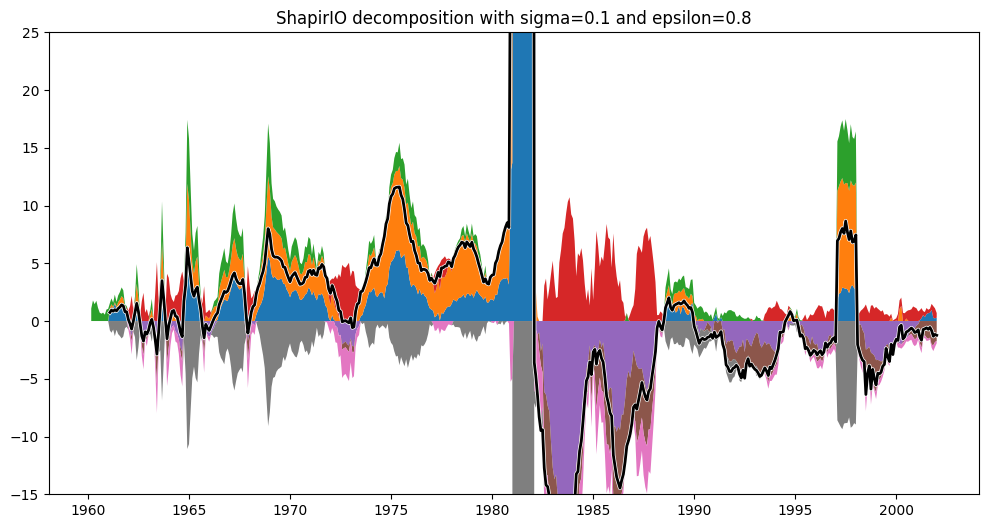

In [ ]:
import matplotlib.pyplot as plt

# Plotting
figsize = (12, 6)

fig, ax = plt.subplots(figsize=figsize)
names_to_bar_plot = ['Supply', 'Demand',  'Unclassified', 'Interaction']
time_axis = contribs_wide.index

i=0
bottom_pos = np.zeros(len(contribs_wide['CPI_rolling'].values))
bottom_neg = np.zeros(len(contribs_wide['CPI_rolling'].values))

    
positive_contribs = np.maximum(contribs_wide[names_to_bar_plot].values, 0)
negative_contribs = np.minimum(contribs_wide[names_to_bar_plot].values, 0)

positive_contribs[np.isnan(positive_contribs)]=0
negative_contribs[np.isnan(negative_contribs)]=0
ax.stackplot(time_axis, positive_contribs[:,0],positive_contribs[:,1],
             positive_contribs[:,2],positive_contribs[:,3],
       color = ['#3582C2','#FF8000','#DCB5DF',"#F4D432"])
ax.stackplot(time_axis, negative_contribs[:,0],negative_contribs[:,1],
             negative_contribs[:,2],negative_contribs[:,3],
       color = colors_hex[0:3])





# Plot overall CPI
ax.plot(time_axis, contribs_wide['CPI_rolling'], color='white', linewidth=3, label='Overall CPI')
ax.plot(time_axis, contribs_wide['CPI_rolling'], color='black', linewidth=2, label='Overall CPI')
ax.set_title('ShapirIO decomposition with sigma=0.1 and epsilon=0.8')
plt.ylim((-15, 25))


In [83]:
def month_over_month_product_inflation(df):
    """Function to Calculate month over month product specific inflation"""
    # Ensure sorted by product and time
    df = df.sort_values(by=['products', 'month'])
    # Group by product and compute year-over-year inflation
    df['inflation percent'] = df.groupby('products')['prices'].transform(lambda x: ((x - x.shift(1)) / x.shift(1)))
        
    return df

In [85]:

D_shapiro = residuals_normal.pivot(index='products', columns='date', values='majority_demand')
# Import Raw PRice again and clean
prices = pd.read_excel(os.path.join(raw_data_path, 'BEA Monthly Prices.xlsx'))
prices = clean_bea_PQE_table(prices, "prices")
# Filter for the 210 BEA products that we actually use
prices = prices.loc[prices.index.intersection(D_shapiro.index)]
prices = prices[~prices.index.duplicated(keep='first')]
prices = prices.reset_index()

# Find month over month product specific infaltion starting form 1960-02
prices_long = pd.melt(prices, id_vars='products', var_name='month', value_name='prices')
prices_long['prices'] = pd.to_numeric(prices_long['prices'], errors='coerce')
inflation = month_over_month_product_inflation(prices_long)
inflation = inflation.pivot(index='products', columns='month', values='inflation percent')
inflation = inflation.iloc[:, 13:]
inflation

month,1960-02-01,1960-03-01,1960-04-01,1960-05-01,1960-06-01,1960-07-01,1960-08-01,1960-09-01,1960-10-01,1960-11-01,...,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01
products,,,,,,,,,,,,,,,,,,,,,
accessories and parts,-0.002218,-0.002364,0.002264,0.002329,0.000176,0.000000,0.002323,0.000176,0.004741,0.000035,...,-0.024595,0.015813,0.005192,-0.010657,0.007386,0.005628,-0.004430,0.009048,0.003366,0.003169
air transportation,0.007913,0.007902,0.011710,0.011574,0.000000,0.007661,-0.003801,0.007582,0.003787,0.007546,...,0.014087,-0.000192,-0.000743,0.010979,-0.020875,-0.015338,-0.016413,0.004218,0.003528,0.026839
alcohol in purchased meals,0.006162,0.000000,-0.009136,-0.003141,0.003151,0.003040,0.000101,0.003030,-0.009264,-0.003049,...,0.002391,0.000419,-0.007216,0.003521,0.003355,0.000733,0.003655,0.000770,0.001996,0.000624
all other professional medical services,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000009,0.006482,-0.003002,0.006159,-0.007885,-0.000036,0.004457,0.001116,-0.000480,0.015443
"amusement parks, campgrounds, and related recreational services",-0.000079,0.005838,0.006746,-0.003194,-0.000469,0.004848,0.002568,0.000699,-0.001241,0.000699,...,0.015514,0.003535,0.004040,-0.008219,0.001624,0.002832,0.001420,0.003509,-0.000841,-0.007317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
water transportation,-0.023813,0.015467,0.000000,0.046530,-0.022246,0.000000,0.000000,0.000000,0.022752,-0.009231,...,-0.022957,0.002243,-0.031343,0.019862,0.006654,-0.013392,0.035566,-0.009492,-0.021580,-0.012017
window coverings,0.010661,0.007580,0.015590,0.010723,0.020210,0.004588,0.004734,0.009904,0.003187,-0.000557,...,0.000586,-0.003744,0.000625,0.026364,0.013529,-0.033182,0.029762,-0.026221,0.042682,-0.006833
wine,0.005062,0.000000,0.000273,0.002264,0.000117,0.000078,-0.000195,0.004712,-0.002403,0.000117,...,-0.000650,0.006843,0.005727,-0.001485,0.000551,0.000964,-0.000844,-0.002239,0.001996,0.002249


In [58]:
# Get expenditure weights
bea_expenditures = bea_expenditures.pivot(index='products', columns='date', values='Expenditures')
expenditure_weights = bea_expenditures.div(bea_expenditures.sum(axis=0), axis=1)
expenditure_weights = expenditure_weights.iloc[:, 13:]
expenditure_weights

date,1960-02-01,1960-03-01,1960-04-01,1960-05-01,1960-06-01,1960-07-01,1960-08-01,1960-09-01,1960-10-01,1960-11-01,...,2023-12-01,2024-01-01,2024-02-01,2024-03-01,2024-04-01,2024-05-01,2024-06-01,2024-07-01,2024-08-01,2024-09-01
products,,,,,,,,,,,,,,,,,,,,,
accessories and parts,0.002916,0.002855,0.002991,0.002906,0.002926,0.002917,0.002907,0.002893,0.002894,0.002873,...,0.003673,0.003649,0.003630,0.003654,0.003633,0.003630,0.003591,0.003613,0.003609,0.003606
air transportation,0.002054,0.002032,0.002013,0.002068,0.002124,0.002178,0.002236,0.002245,0.002250,0.002263,...,0.009237,0.009358,0.009431,0.009307,0.009153,0.009417,0.009162,0.009005,0.009236,0.009391
alcohol in purchased meals,0.013582,0.013665,0.013773,0.013858,0.013933,0.013750,0.013421,0.013390,0.013211,0.013623,...,0.008195,0.008116,0.008081,0.008012,0.008041,0.008002,0.007992,0.007989,0.008007,0.008050
all other professional medical services,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.004938,0.005015,0.004973,0.005023,0.004995,0.004971,0.004994,0.004984,0.005001,0.005098
"amusement parks, campgrounds, and related recreational services",0.002835,0.002795,0.002760,0.002830,0.002840,0.002838,0.002847,0.002821,0.002819,0.002823,...,0.004921,0.004934,0.004883,0.004892,0.004587,0.004491,0.004540,0.004579,0.004559,0.004479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
water transportation,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,0.000003,...,0.000338,0.000330,0.000323,0.000320,0.000334,0.000341,0.000343,0.000350,0.000357,0.000362
window coverings,0.002641,0.002578,0.002616,0.002565,0.002662,0.002609,0.002578,0.002515,0.002638,0.002529,...,0.001611,0.001589,0.001566,0.001585,0.001557,0.001549,0.001558,0.001555,0.001539,0.001536
wine,0.001747,0.001736,0.001717,0.001743,0.001762,0.001794,0.001748,0.001747,0.001755,0.001799,...,0.003611,0.003560,0.003559,0.003559,0.003544,0.003532,0.003562,0.003549,0.003535,0.003541


In [60]:
# IO Classification Aggregated Monthly Inflation
inflation_parts_IO = {}

for date in expenditure_weights:
    current_demand = D_IO[str(date)] # all products calssified as demand for this period
    current_supply = 1 - current_demand # all products calssified as supply for this period

    current_weights = expenditure_weights[date] # all product weights for this period
    current_inflation = inflation[date] # all product specific inflation for this period

    demand_inflation = (current_demand * current_weights * current_inflation).sum() # Aggregated montly demand driven inflation
    supply_inflation = (current_supply * current_weights * current_inflation).sum() # Aggregated montly supply driven inflation

    inflation_parts_IO[date] = [demand_inflation, supply_inflation] # Store each month's data

# Final demand and supply driven inflation
inflation_IO_final = pd.DataFrame(inflation_parts_IO, index=['demand_inflation', 'supply_inflation'])
inflation_IO_final = inflation_IO_final.T

# Shapiro Classification Aggregated Monthly Inflation
inflation_parts_shapiro = {}

for date in expenditure_weights:
    current_demand = D_shapiro[str(date)]
    current_supply = 1 - current_demand

    current_weights = expenditure_weights[date]
    current_inflation = inflation[date]

    demand_inflation = (current_demand * current_weights * current_inflation).sum()
    supply_inflation = (current_supply * current_weights * current_inflation).sum()

    inflation_parts_shapiro[date] = [demand_inflation, supply_inflation]


inflation_shapiro_final = pd.DataFrame(inflation_parts_shapiro, index=['demand_inflation', 'supply_inflation'])
inflation_shapiro_final = inflation_shapiro_final.T
inflation_shapiro_final

,demand_inflation,supply_inflation
1960-02-01,-0.000334,0.001211
1960-03-01,0.000513,0.000042
1960-04-01,0.001833,0.001781
1960-05-01,-0.000284,0.001335
1960-06-01,0.000082,0.000331
...,...,...
2024-05-01,0.001389,-0.001388
2024-06-01,0.000250,0.000920
2024-07-01,0.000290,0.001378
2024-08-01,0.000838,0.000411


In [61]:
# IO Classification - Anual Supply Inflation
inflation_IO_final['annual_supply_inflation'] = (
    (inflation_IO_final['supply_inflation'].add(1).shift(1).rolling(window=12, min_periods=12).apply(np.prod, raw=True) - 1) * 100
)
# IO Classification - Anual Demand Inflation
inflation_IO_final['annual_demand_inflation'] = (
    (inflation_IO_final['demand_inflation'].add(1).shift(1).rolling(window=12, min_periods=12).apply(np.prod, raw=True) - 1) * 100
)
# Shapiro Classification - Anual Supply Inflation
inflation_shapiro_final['annual_supply_inflation'] = (
    (inflation_shapiro_final['supply_inflation'].add(1).shift(1).rolling(window=12, min_periods=12).apply(np.prod, raw=True) - 1) * 100
)
# Shapiro Classification - Anual Demand Inflation
inflation_shapiro_final['annual_demand_inflation'] = (
    (inflation_shapiro_final['demand_inflation'].add(1).shift(1).rolling(window=12, min_periods=12).apply(np.prod, raw=True) - 1) * 100
)

In [62]:
def plot_graphs(data, plot_title, plot_text):
    data = data.loc[data.index >= pd.Timestamp('1970-01-01')]

    supply_inflation = data[["annual_supply_inflation"]].copy()
    supply_inflation.rename(columns={'annual_supply_inflation': 'Supply Inflation'}, inplace=True)

    demand_inflation = data[["annual_demand_inflation"]].copy()
    demand_inflation.rename(columns={'annual_demand_inflation': 'Demand Inflation'}, inplace=True)

    supply_inflation['supply_pos'] = supply_inflation['Supply Inflation'].apply(lambda x: x if x > 0 else 0)
    demand_inflation['demand_pos'] = demand_inflation['Demand Inflation'].apply(lambda x: x if x > 0 else 0)
    supply_inflation['supply_neg'] = supply_inflation['Supply Inflation'].apply(lambda x: x if x < 0 else 0)
    demand_inflation['demand_neg'] = demand_inflation['Demand Inflation'].apply(lambda x: x if x < 0 else 0)

    demand_inflation = demand_inflation.iloc[:-1]
    supply_inflation = supply_inflation.iloc[:-1]

    plt.figure(figsize=(26, 12))

    plt.stackplot(supply_inflation.index, demand_inflation['demand_pos'], supply_inflation['supply_pos'], colors= ["#008000", "#FF0000"], labels = ["Deamnd", "Supply"])
    plt.stackplot(supply_inflation.index, demand_inflation['demand_neg'], supply_inflation['supply_neg'], colors= ["#008000", "#FF0000"])
    plt.xlabel('Date')
    plt.ylabel('Inflation')
    plt.title(f'{plot_title}')
    plt.legend()

    plt.text(0.02, 0.95, 
         f'{plot_text}', 
         transform=plt.gca().transAxes, fontsize=9,
         bbox=dict(facecolor='white', alpha=0.8))

    return plt

<module 'matplotlib.pyplot' from '/Users/Nick/Desktop/github testing/ShapirIO_new/.venv/lib/python3.13/site-packages/matplotlib/pyplot.py'>

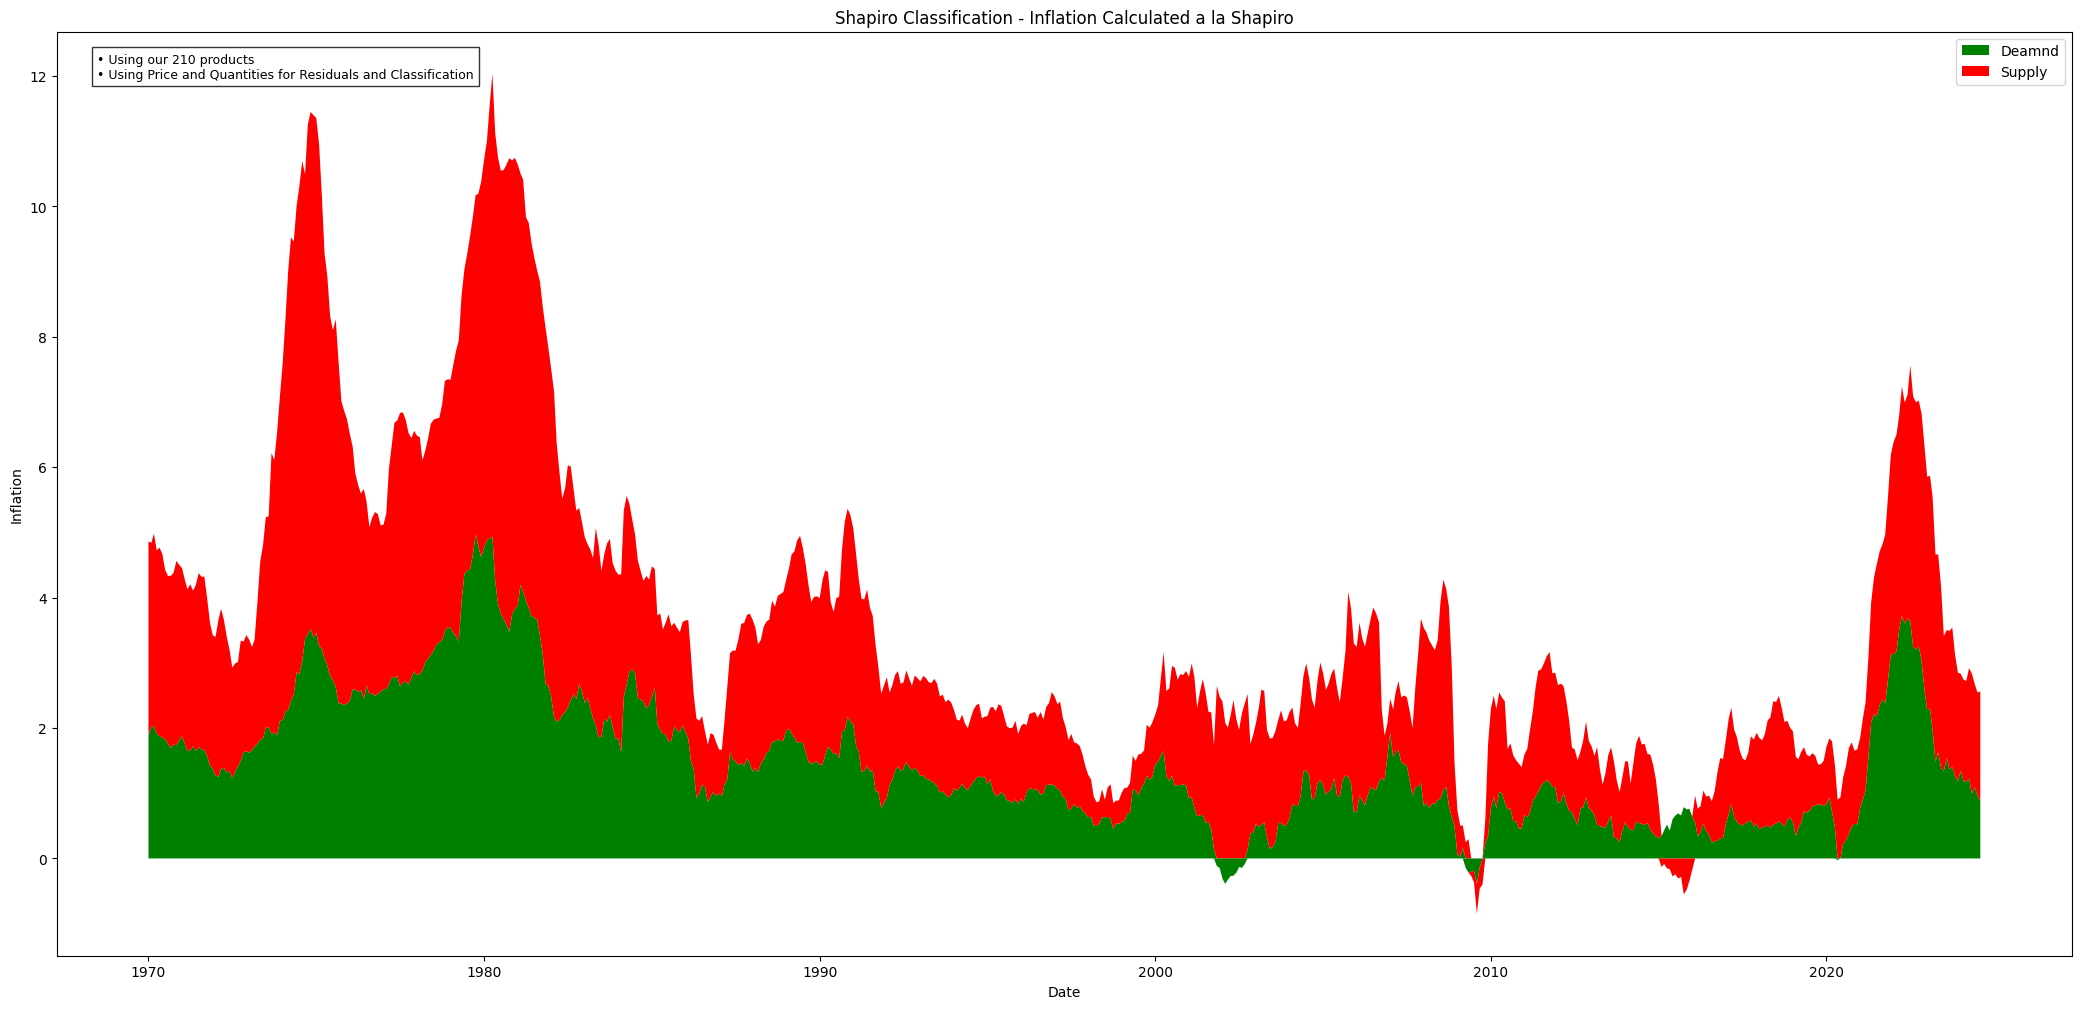

In [63]:
plot_graphs(inflation_shapiro_final, "Shapiro Classification - Inflation Calculated a la Shapiro", "• Using our 210 products \n• Using Price and Quantities for Residuals and Classification")

<module 'matplotlib.pyplot' from '/Users/Nick/Desktop/github testing/ShapirIO_new/.venv/lib/python3.13/site-packages/matplotlib/pyplot.py'>

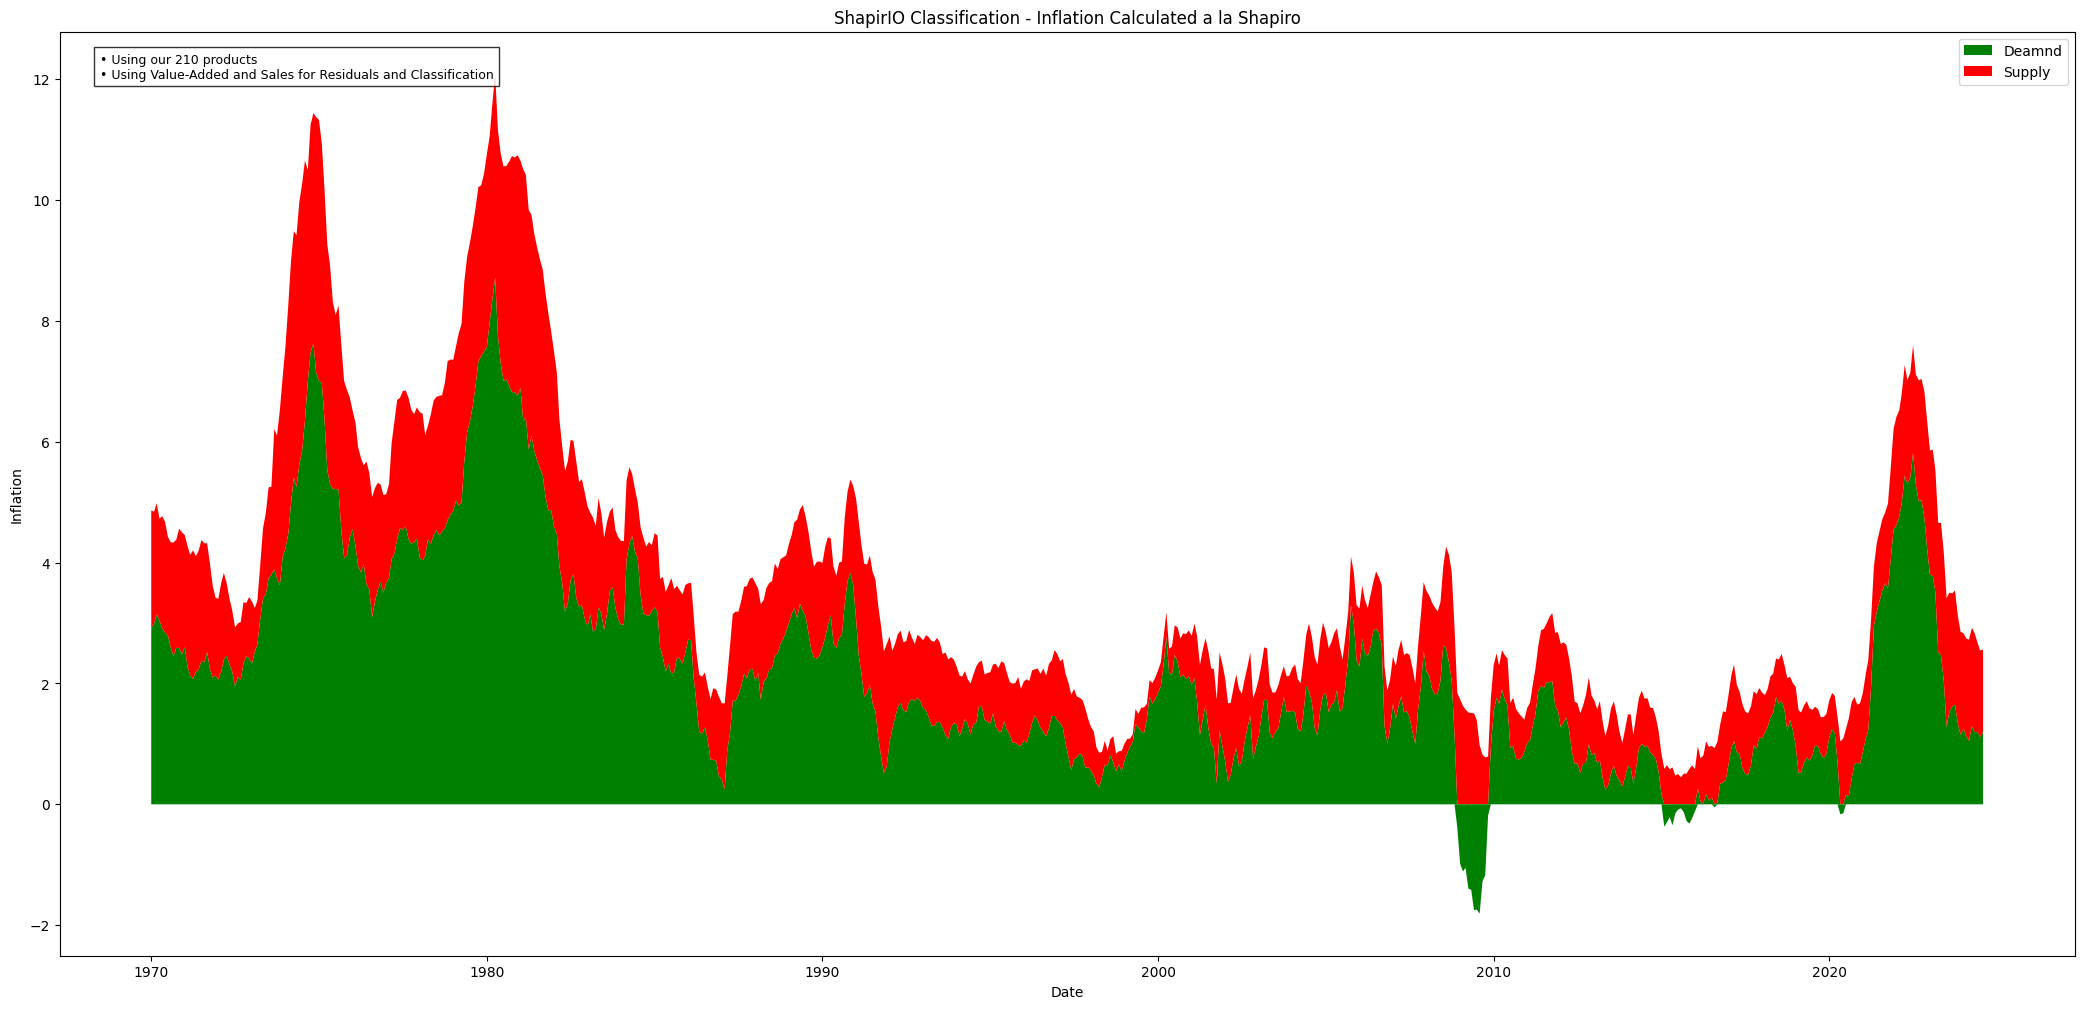

In [64]:
plot_graphs(inflation_IO_final, "ShapirIO Classification - Inflation Calculated a la Shapiro", "• Using our 210 products \n• Using Value-Added and Sales for Residuals and Classification")

C:\Users\TonyGui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\indexes\base.py:7631: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(index_like, name=name, copy=copy)
C:\Users\TonyGui\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pandas\core\indexes\base.py:7631: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(index_like, name=name, copy=copy)


<module 'matplotlib.pyplot' from 'C:\\Users\\TonyGui\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\matplotlib\\pyplot.py'>

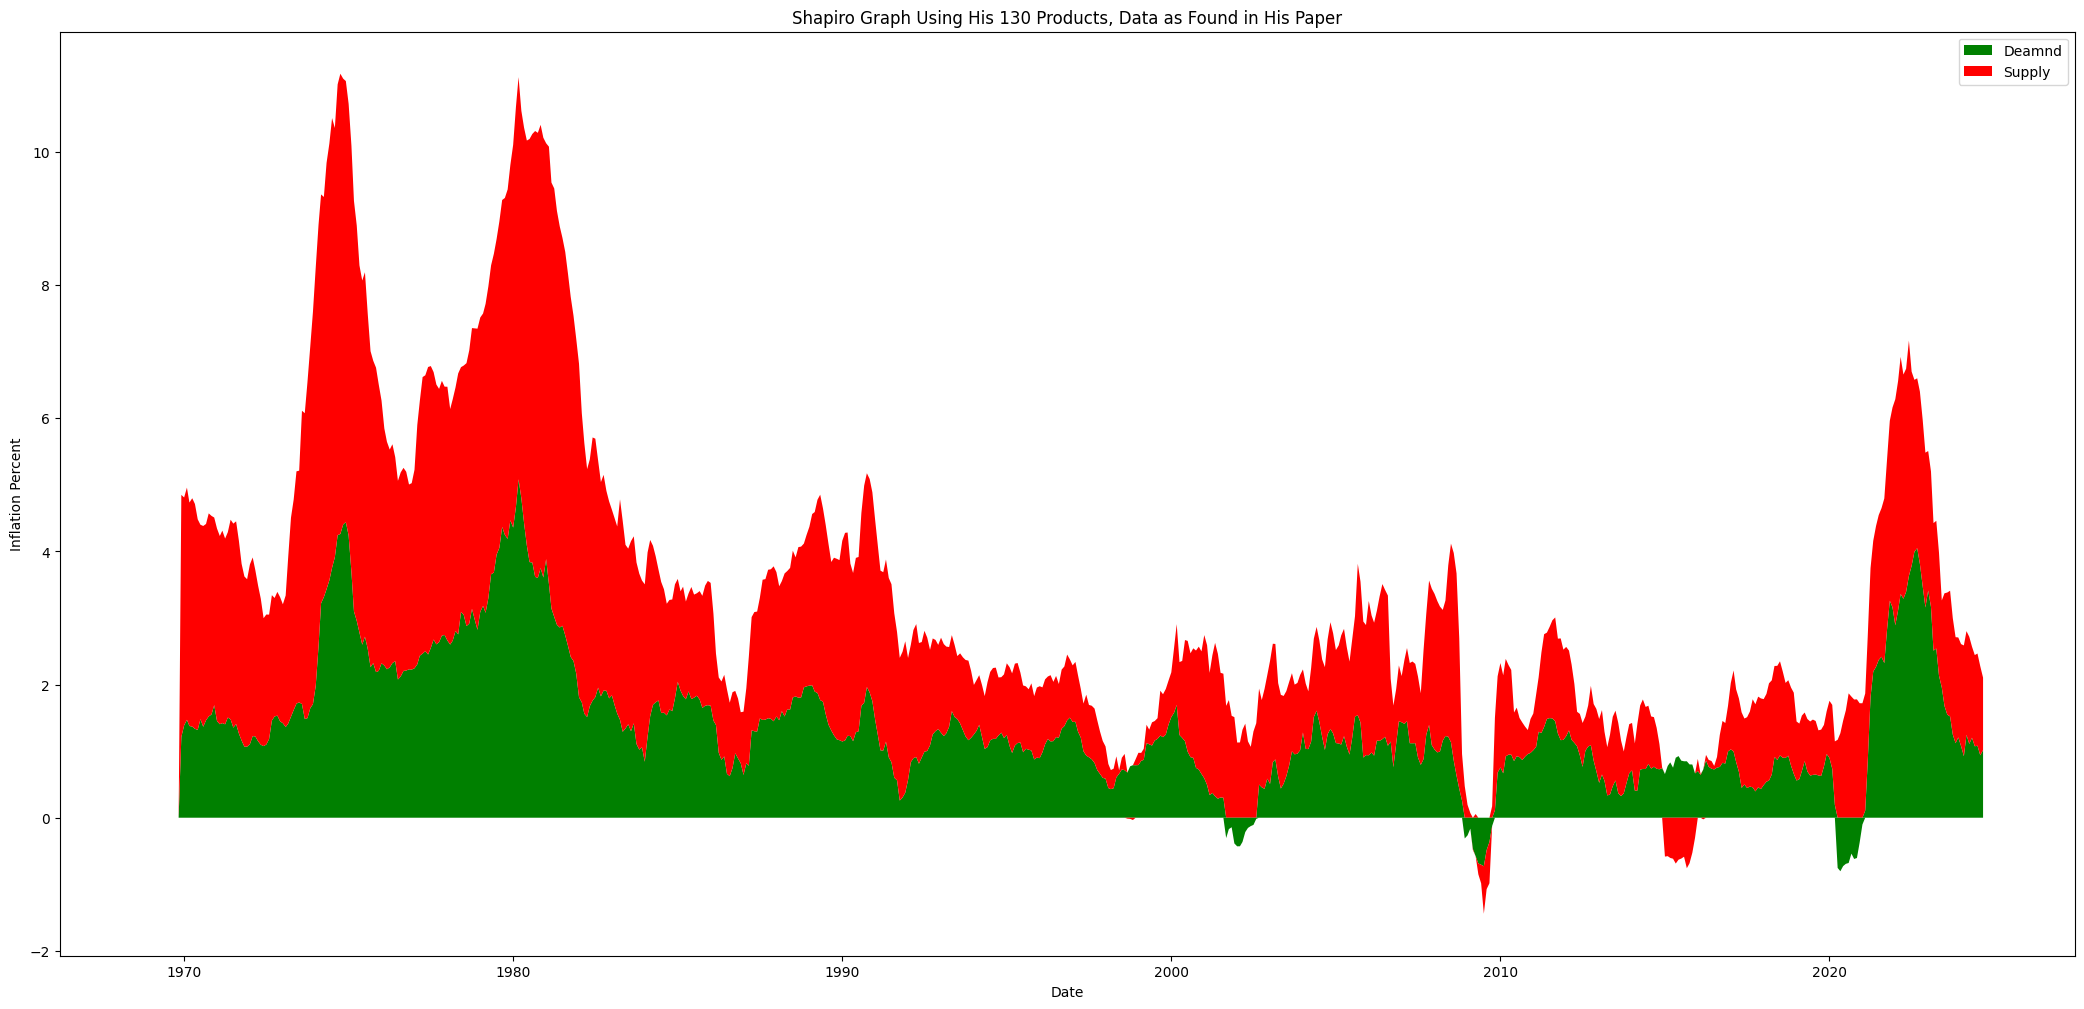

In [139]:
shapiro_code_output = pd.read_excel(os.path.join(shapiro_file, 'shaprio_stata_output_excel.xlsx'))
haver_code_concordance = pd.read_excel(os.path.join(shapiro_file, 'Haver Codes to Product Names.xlsx'))
mapping = dict(zip(haver_code_concordance['Shapiro Price Name'], haver_code_concordance['PCE Category']))

""" I dont know why but in Shapiro's output the expenditure for water transport is titled s"""
mapping["s"] = "Water transportation (65)"
expenditure_weights = get_expenditure_weights_from_shapiro_outputs(shapiro_code_output, mapping)
demand_shock = get_demand_shock_from_shaipro_output(shapiro_code_output, mapping)

shapiro_graph = plot_shapiro_graph_from_shapiro_ouput(shapiro_code_output, "Shapiro Graph Using His 130 Products, Data as Found in His Paper")
shapiro_graph

## 3. An Alternative way to Calculate Inflation - Log Difference

In [140]:
def month_inflation_althernative(df):
    """Function to Calculate month over month product specific inflation using log differneces"""
    # Ensure sorted by product and time
    df = df.sort_values(by=['products', 'month'])
    # Group by product and compute year-over-year inflation
    df['inflation log differnece'] = df.groupby('products')['prices'].transform(lambda x: (np.log(x) - np.log(x.shift(1))))
        
    return df

In [141]:
inflation_log_difference = month_inflation_althernative(prices_long)
inflation_log_difference = inflation_log_difference.pivot(index='products', columns='month', values='inflation log differnece')
inflation_log_difference = inflation_log_difference.iloc[:, 13:]

In [ ]:
# IO Classification Aggregated Monthly Inflation
inflation_log_parts_IO = {}

for date in expenditure_weights:
    current_demand = D_IO[str(date)] # all products calssified as demand for this period
    current_supply = 1 - current_demand # all products calssified as supply for this period

    current_weights = expenditure_weights[date] # all product weights for this period
    current_inflation = inflation_log_difference[date] # all product specific inflation for this period

    demand_inflation = (current_demand * current_weights * current_inflation).sum() # Aggregated montly demand driven inflation
    supply_inflation = (current_supply * current_weights * current_inflation).sum() # Aggregated montly supply driven inflation

    inflation_log_parts_IO[date] = [demand_inflation, supply_inflation] # Store each month's data

# Final demand and supply driven inflation
inflation_log_IO_final = pd.DataFrame(inflation_log_parts_IO, index=['demand_inflation_log', 'supply_inflation_log'])
inflation_log_IO_final = inflation_log_IO_final.T

# Shapiro Classification Aggregated Monthly Inflation
inflation_log_parts_shapiro = {}

for date in expenditure_weights:
    current_demand = D_shapiro[str(date)]
    current_supply = 1 - current_demand

    current_weights = expenditure_weights[date]
    current_inflation = inflation_log_difference[date]

    demand_inflation = (current_demand * current_weights * current_inflation).sum()
    supply_inflation = (current_supply * current_weights * current_inflation).sum()

    inflation_log_parts_shapiro[date] = [demand_inflation, supply_inflation]


inflation_log_shapiro_final = pd.DataFrame(inflation_log_parts_shapiro, index=['demand_inflation_log', 'supply_inflation_log'])
inflation_log_shapiro_final = inflation_log_shapiro_final.T

In [ ]:
# IO Classification - Anual Supply Inflation
inflation_log_IO_final['annual_supply_inflation'] = (
    (inflation_log_IO_final['supply_inflation_log'].rolling(window=12, min_periods=12).sum()) * 100
)
# IO Classification - Anual Demand Inflation
inflation_log_IO_final['annual_demand_inflation'] = (
    (inflation_log_IO_final['demand_inflation_log'].rolling(window=12, min_periods=12).sum()) * 100
)
# Shapiro Classification - Anual Supply Inflation
inflation_log_shapiro_final['annual_supply_inflation'] = (
    (inflation_log_shapiro_final['supply_inflation_log'].rolling(window=12, min_periods=12).sum()) * 100
)
# Shapiro Classification - Anual Demand Inflation
inflation_log_shapiro_final['annual_demand_inflation'] = (
    (inflation_log_shapiro_final['demand_inflation_log'].rolling(window=12, min_periods=12).sum()) * 100
)

<module 'matplotlib.pyplot' from 'C:\\Users\\TonyGui\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\matplotlib\\pyplot.py'>

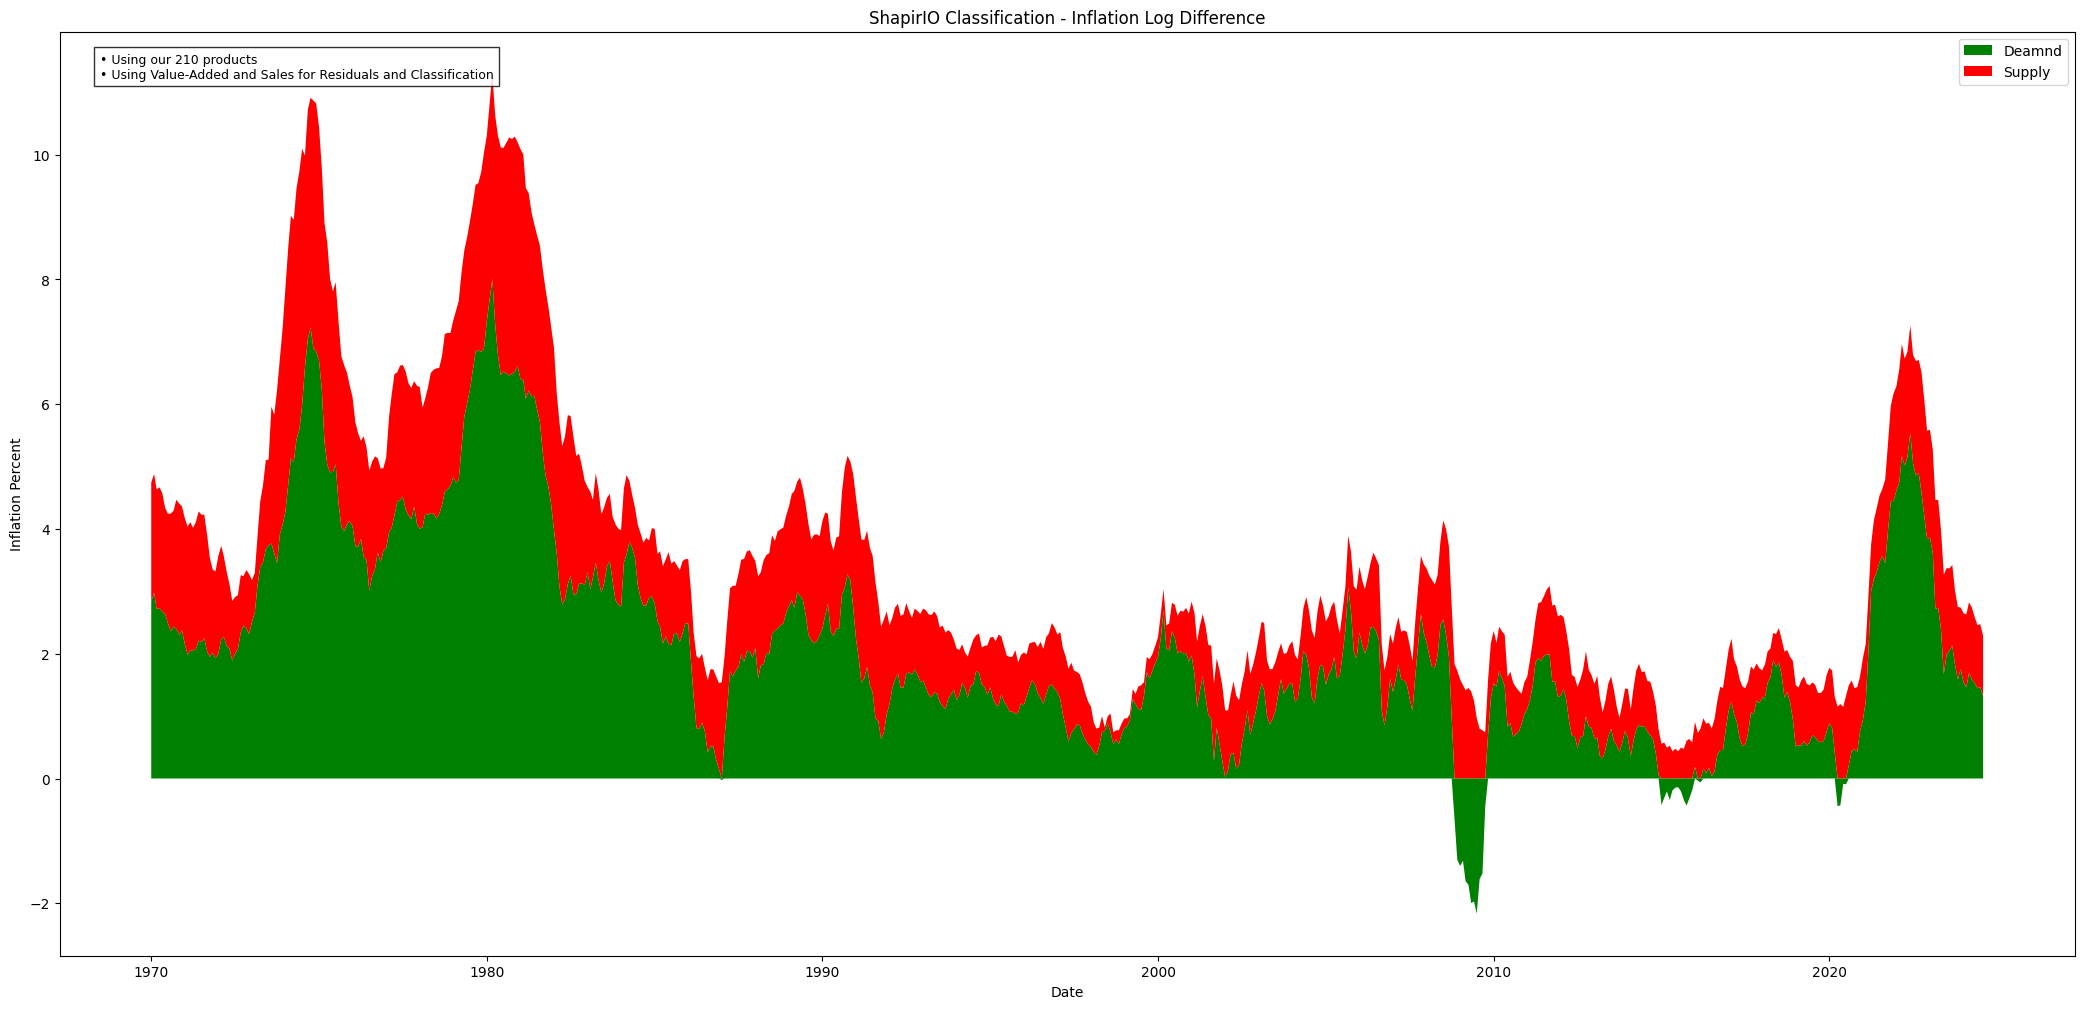

In [ ]:
plot_graphs(inflation_log_IO_final, "ShapirIO Classification - Inflation Log Difference", "• Using our 210 products \n• Using Value-Added and Sales for Residuals and Classification")

<module 'matplotlib.pyplot' from 'C:\\Users\\TonyGui\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\matplotlib\\pyplot.py'>

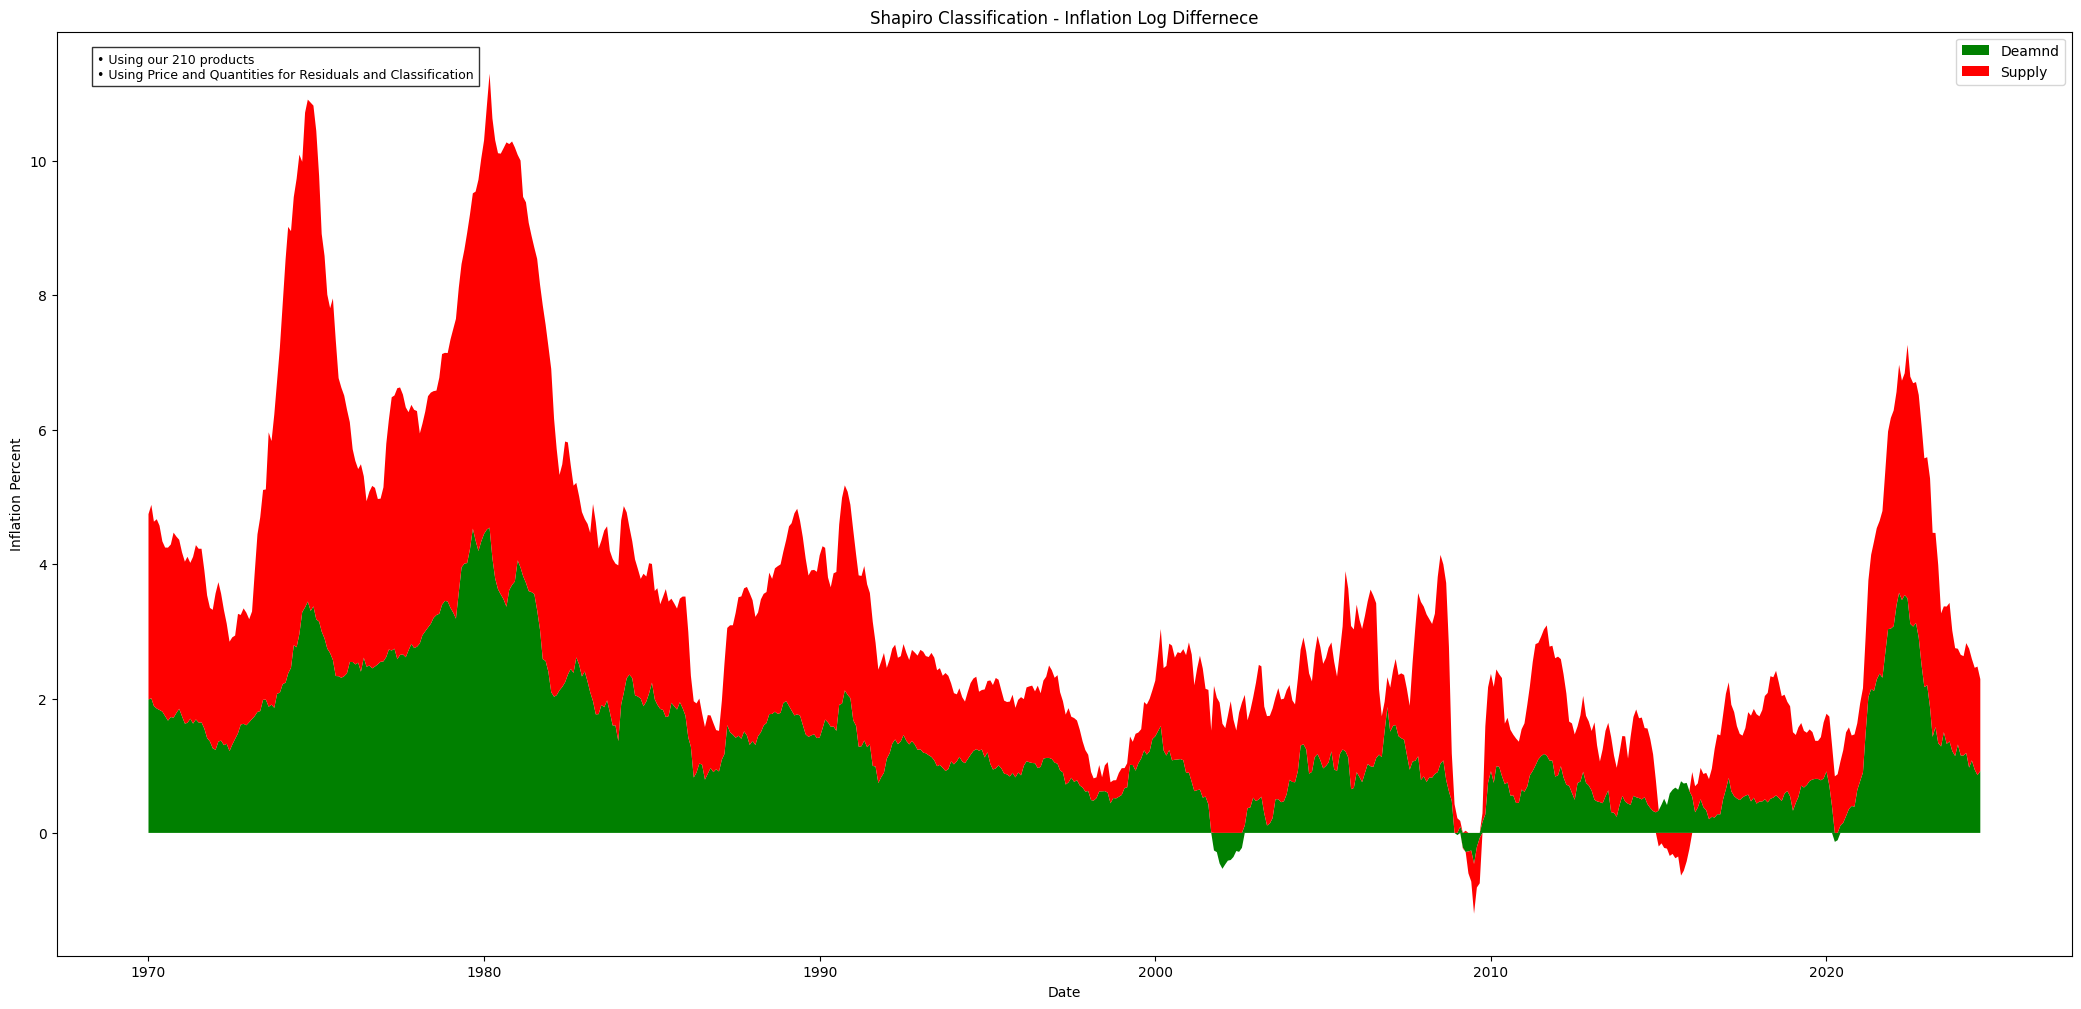

In [ ]:
plot_graphs(inflation_log_shapiro_final, "Shapiro Classification - Inflation Log Differnece", "• Using our 210 products \n• Using Price and Quantities for Residuals and Classification")

## 3. Using D Influence

In [ ]:
"""Inflation a la Shapiro"""
inflation_parts_IO_influence = {}

for date in expenditure_weights:
    current_demand = D_influence[str(date)] # all products calssified as demand for this period
    current_supply = 1 - current_demand # all products calssified as supply for this period

    current_weights = expenditure_weights[date] # all product weights for this period
    current_inflation = inflation[date] # all product specific inflation for this period

    demand_inflation = (current_demand * current_weights * current_inflation).sum() # Aggregated montly demand driven inflation
    supply_inflation = (current_supply * current_weights * current_inflation).sum() # Aggregated montly supply driven inflation

    inflation_parts_IO_influence[date] = [demand_inflation, supply_inflation] # Store each month's data 

# Final demand and supply driven inflation
inflation_IO_influence = pd.DataFrame(inflation_parts_IO_influence, index=['demand_inflation', 'supply_inflation'])
inflation_IO_influence = inflation_IO_influence.T

"""Inflation Log Difference"""
inflation_parts_IO_log = {}

for date in expenditure_weights:
    current_demand = D_influence[str(date)] # all products calssified as demand for this period
    current_supply = 1 - current_demand # all products calssified as supply for this period

    current_weights = expenditure_weights[date] # all product weights for this period
    current_inflation = inflation_log_difference[date] # all product specific inflation for this period

    demand_inflation = (current_demand * current_weights * current_inflation).sum() # Aggregated montly demand driven inflation
    supply_inflation = (current_supply * current_weights * current_inflation).sum() # Aggregated montly supply driven inflation

    inflation_parts_IO_log[date] = [demand_inflation, supply_inflation] # Store each month's data

# Final demand and supply driven inflation
inflation_IO_influence_log = pd.DataFrame(inflation_parts_IO_log, index=['demand_inflation_log', 'supply_inflation_log'])
inflation_IO_influence_log = inflation_IO_influence_log.T

# Anual Supply Inflation - a la Shapiro
inflation_IO_influence['annual_supply_inflation'] = (
    (inflation_IO_influence['supply_inflation'].add(1).shift(1).rolling(window=12, min_periods=12).apply(np.prod, raw=True) - 1) * 100
)
# Anual Demand Inflation - a la Shapiro
inflation_IO_influence['annual_demand_inflation'] = (
    (inflation_IO_influence['demand_inflation'].add(1).shift(1).rolling(window=12, min_periods=12).apply(np.prod, raw=True) - 1) * 100
)
# Anual Supply Inflation - Log Difference
inflation_IO_influence_log['annual_supply_inflation'] = (
    (inflation_IO_influence_log['supply_inflation_log'].rolling(window=12, min_periods=12).sum()) * 100
)
# Anual Demand Inflation - Log Difference 
inflation_IO_influence_log['annual_demand_inflation'] = (
    (inflation_IO_influence_log['demand_inflation_log'].rolling(window=12, min_periods=12).sum()) * 100
)

<module 'matplotlib.pyplot' from 'C:\\Users\\TonyGui\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\matplotlib\\pyplot.py'>

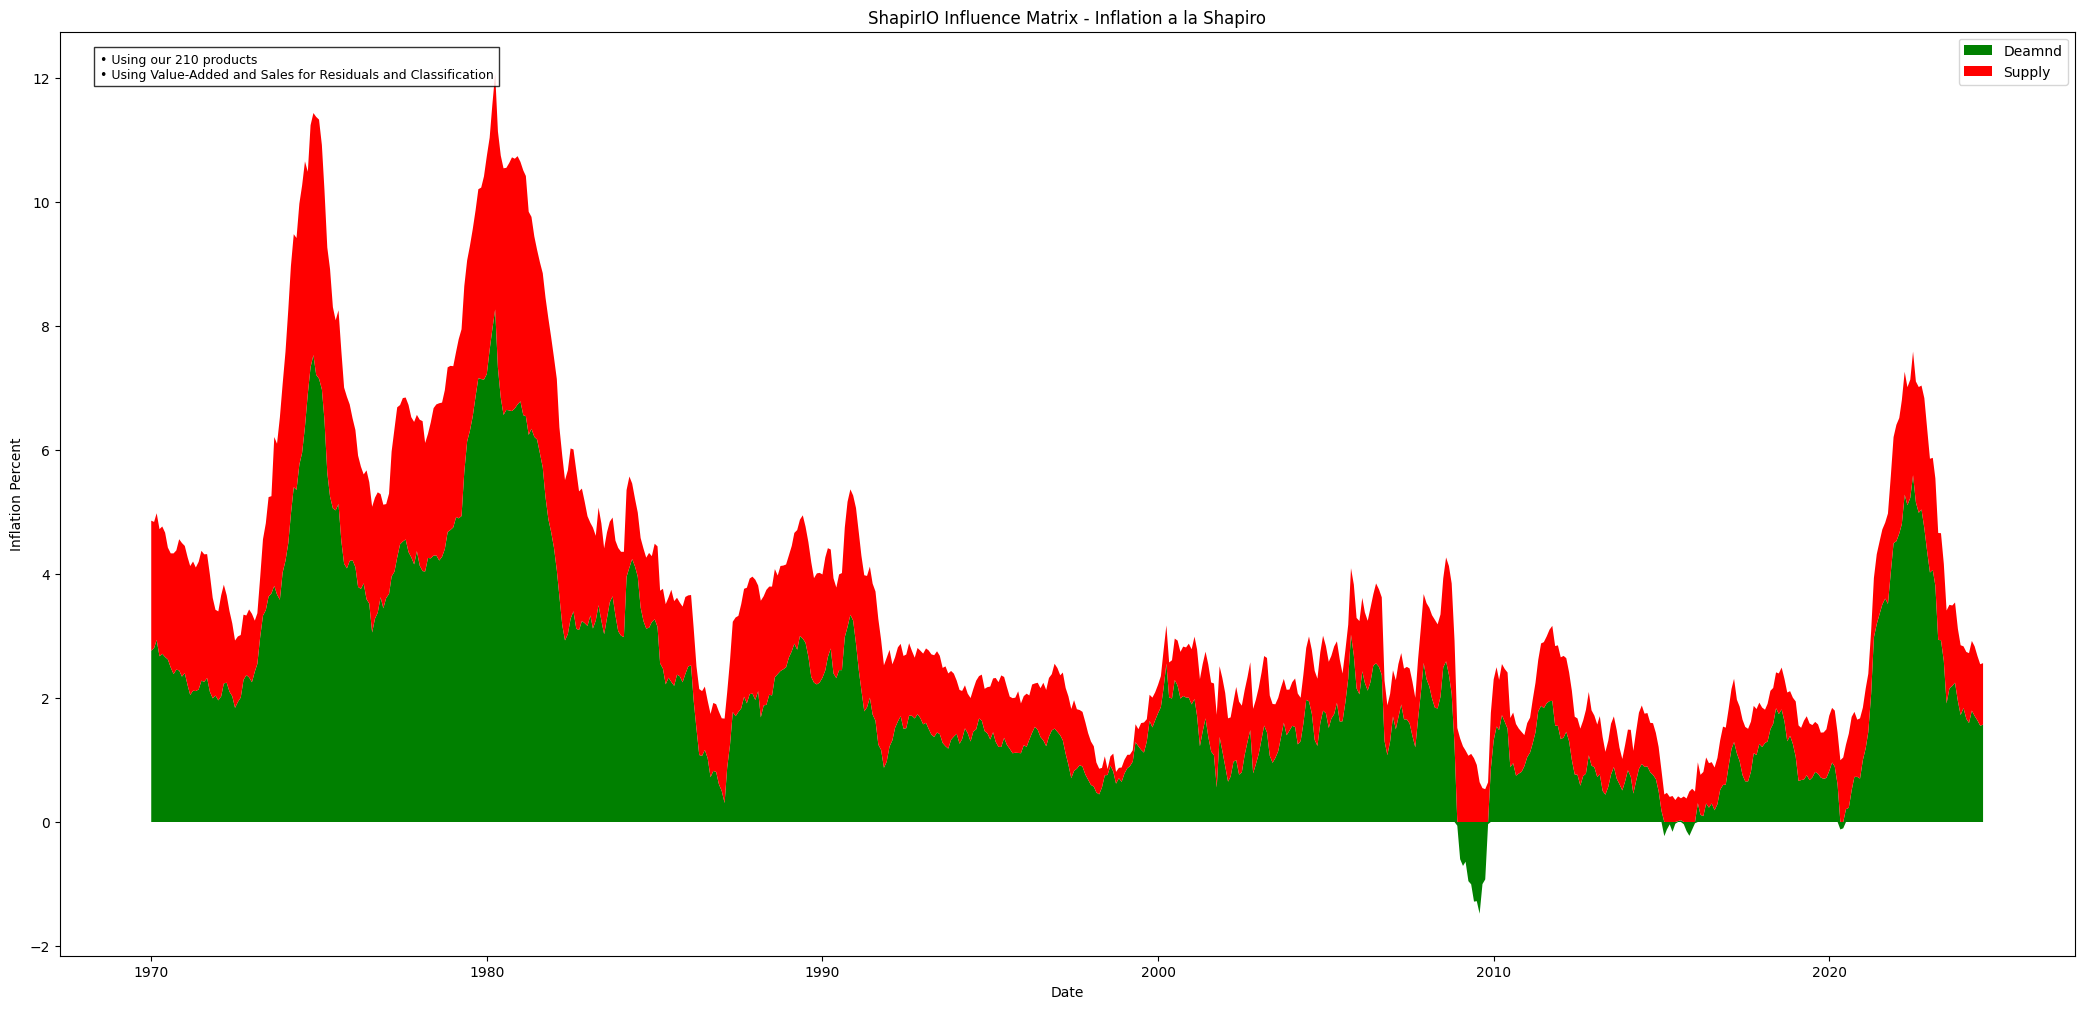

In [ ]:
plot_graphs(inflation_IO_influence, "ShapirIO Influence Matrix - Inflation a la Shapiro", "• Using our 210 products \n• Using Value-Added and Sales for Residuals and Classification")

<module 'matplotlib.pyplot' from 'C:\\Users\\TonyGui\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python312\\site-packages\\matplotlib\\pyplot.py'>

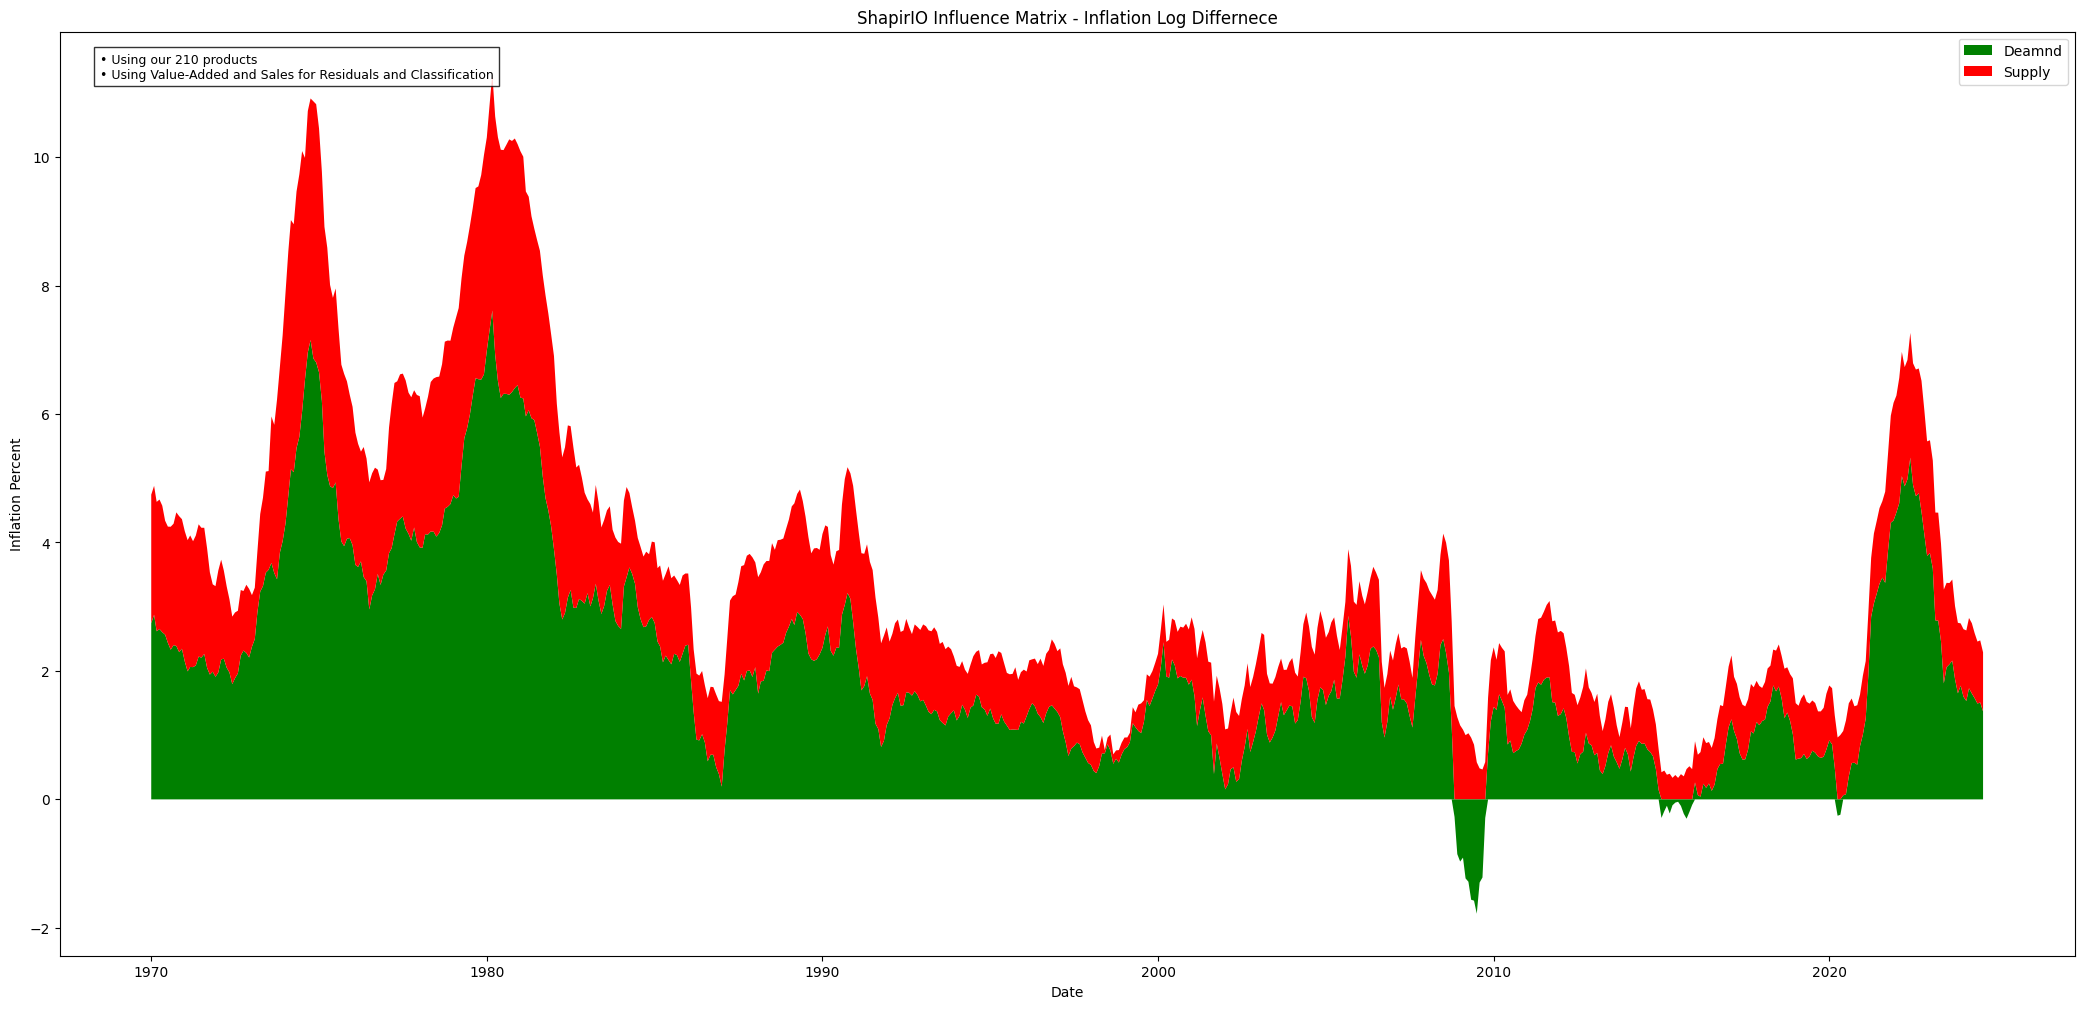

In [ ]:
plot_graphs(inflation_IO_influence_log, "ShapirIO Influence Matrix - Inflation Log Differnece", "• Using our 210 products \n• Using Value-Added and Sales for Residuals and Classification")

In [ ]:
inflation_IO_influence

,demand_inflation,supply_inflation,annual_supply_inflation,annual_demand_inflation
1960-02-01,-0.000096,0.000972,NaN,NaN
1960-03-01,0.001069,-0.000514,NaN,NaN
1960-04-01,0.003364,0.000250,NaN,NaN
1960-05-01,-0.000412,0.001463,NaN,NaN
1960-06-01,-0.000521,0.000934,NaN,NaN
...,...,...,...,...
2024-05-01,0.000234,-0.000234,1.122928,1.711065
2024-06-01,0.000811,0.000359,1.040184,1.637665
2024-07-01,0.001555,0.000113,0.991874,1.553043
2024-08-01,0.000767,0.000483,0.992536,1.569746


In [ ]:
inflation_IO_final

,demand_inflation,supply_inflation,annual_supply_inflation,annual_demand_inflation
1960-02-01,-0.000194,0.001070,NaN,NaN
1960-03-01,0.001367,-0.000812,NaN,NaN
1960-04-01,0.003720,-0.000106,NaN,NaN
1960-05-01,-0.000585,0.001637,NaN,NaN
1960-06-01,-0.000672,0.001085,NaN,NaN
...,...,...,...,...
2024-05-01,0.000218,-0.000218,1.181442,1.652059
2024-06-01,0.000813,0.000357,1.083344,1.594079
2024-07-01,0.001638,0.000030,1.033753,1.510760
2024-08-01,0.000734,0.000515,1.035342,1.526524
